In [231]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, plot_roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm



plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this chapter we will **only talk about classification**. Classifiers associate a transformed set of features to one of two class (a discrete variable): 0 or 1. Even when doing multiclass classification you always go back (thanks to some algo) to a problem of two classes: 0 or 1.


In this notebook we are going to focus on distance based classification method (opposed to decision tree for example). The goal is to give you some insight on 4 different levels:
- **Best practice** 
- **Intuition on the concepts behind those methods**
- **How to implement them with Scikitlearn**
- **Intuition on the different parameters that your model need but are not trainable (hyperparameters)**

# Distance based classification method
## Table Of Content:

* [**K-nearest neighbors : introduction to basic routine in ML**](#neighbors)
    * [Toy dataset: concepts and hyperparameters](#KN-concepts)
    * [Cancer dataset/introduction to relevant metrics](#K-cancer)
    * [Iris dataset: a multiclass dataset ](#MC-KN)
    
    
* [**Logistic regression and the ooportunity to use AUC ROC**](#Logistic-regression)
    * [Concepts: what is linear and introduction to regularization](#Logistic-regression)
    * [Toy dataset: introdution to the AUC ROC](#AUC-ROC)
    * [Iris dataset: how do those concepts translate to multiclass](#MR-LR)
    * [Using AUC ROC to recognize artifact from imbalanced dataset](#Unbalanced)
    * [Cancer dataset: playing around with the Logistic regression hyperparameters](#LR-hyper)
    * [Iris dataset: applying the model](#LR-IRIS)
    
    
* [**Support Vector Machine**](#SVM)
    * [Concepts](#SVM)
    * [Toy dataset with linear kernel](#SVM-linear)
    * [Toy dataset with nonlinear kernel](#SVM-nonlinear)
    * [Cancer dataset: playing with the hyperparameters](#SVM-hyperparameters)
    
    
* [**Exo**](#exo)

In [232]:
# Multiclassification data set
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)


(X_iris, y_iris) = load_iris(return_X_y = True)



#Classification data set
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)



# K-nearest neighbors +  some basic routine <a class="anchor" id="neighbors"></a>

K-nearest neighbors is a pretty simple algorithm in terms of concept but it already has few hyperparameters that you should  understand and try to optimize. It will introduce you to some of the very experimental like routine that machine learning is.

For a classifier, k-nearest neighbors works as follow. **First the algorithm simply saves the labels that it is given during the training phase**. Then during the testing phase it takes a testing point and checks its 'n_neighbors' nearest neighbors. **If 'n_neighbors' nearest neighbors are mostly (in majority) from one label then the tested point will be assigned this label**. The way the 'n_neighbors' **nearest neighbors vote** can be either uniform (every point as the same importance in the vote) or distance (a point distant to the tested point by a distance d will have a weight of 1/d in the vote).

#### Toy data set <a class="anchor" id="KN-concepts"></a>

In [233]:
#Let's make some toy dataset. Here using the sklearn function making blobs for you!!!

from sklearn.datasets import make_blobs
X_3, y_3 = make_blobs(n_samples=120, centers=3,cluster_std=[[1,3],[1,3],[1,3]], random_state=6)# 120 points, 3 blobs/clusters with some spread=3
#Random_state is here just to be sure that every time you will get the same blobs. If you change the random_state or do not
#specify it then you will get a new plot every time you call the function (random seed)

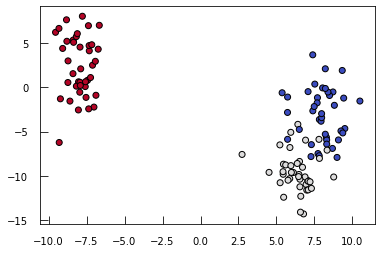

In [234]:
plt.scatter(X_3[:,0],X_3[:,1],c=y_3,cmap=plt.cm.coolwarm,edgecolors='k')
plt.show()

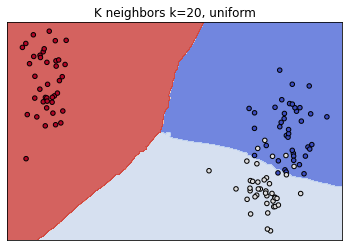

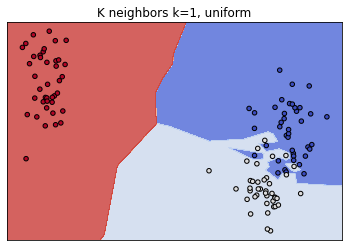

In [235]:
from utils import countour_knn
countour_knn(20,X_3,y_3,'uniform')
countour_knn(1,X_3,y_3,'uniform')

In the above we varied the number of voters (neighbors) to decide weither a point is from one class or another. You can see how the **boundaries are way more wiggly and attentive to missclassification when the number of neighbors is low**. But you can also imagine that if **new data is added those kind of too specific boundaries are going to missclaissify the new points. This is a first example of this bias variance trade off.**

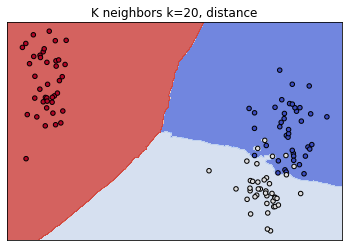

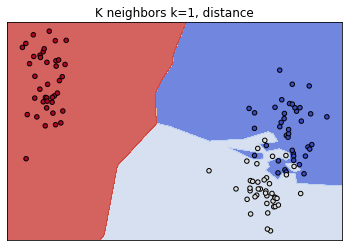

In [236]:
countour_knn(20,X_3,y_3,'distance')
countour_knn(1,X_3,y_3,'distance')

Another parameter is how voting is done. Of course for only 1 neighbors this is the same graph as before. But for 20 neighbors you can see isle of white point in bleu territory : again overfitting.

#### Cancer dataset <a class="anchor" id="K-cancer"></a>

**We will have to divide our data set into a train and a test set**. The **test set should never be touched until the last step which is the model evaluation**. By doing so we can be confident that our measure of generalization efficiency of our model is as correct as it can be. This is why no information coming from the test set should leak into the train set. If so we are biasing our understanding of the generalizability of our model. I would like to give you some examples of that but I will need to use many tools that we haven't touched yet. So for now believe me on the necessity to split dataset. Maybe later when you will have all those tools try to persuade yourself.

In [237]:
from sklearn.model_selection import train_test_split

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer,
                                                   random_state=7,stratify=y_cancer) #default if 75% training, 25% testing

#train_test_split make sure to split the data so that the two partitions ressemble each other statistically speaking
#For example a bad splitting would be that your training set have 99% of one label and your testing set 99% of the other....

Kneighbors = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors.fit(X_cancer_train, y_cancer_train)

y_pred_test=Kneighbors.predict(X_cancer_test)

y_pred_train=Kneighbors.predict(X_cancer_train)


print('Acc= {0:.3f} on train, Acc= {1:.3f} on test'.format(Kneighbors.score(X_cancer_train,y_cancer_train),\
                                                           Kneighbors.score(X_cancer_test,y_cancer_test)))

Acc= 0.946 on train, Acc= 0.944 on test


So far I haven't define way to measure the quality of our classifier. Spoiler alert it is what is above called Acc for Accuracy. I will define what it is so bear with me. For now we have a more important problem:

In the previous example we didn't rescale the data! **It can really important to rescale your data mainly when the method you are using are based on distances (scalar product) or similarity**.This is for the same reasons that we discuss in the PCA part of last notebook, but again it depends only on your understanding of the data.

As K-neighbors method is distance based, and that we know let's rescale data. 

In [238]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler() 
scaler.fit(X_cancer_train)# the scaler is fit only on the train data!!!!!!!! Doing it on the full data set is a perfect case of
#data leakage : you are going to provide a mean and a standard deviation calculated with data containing the test set and 
#that's enough to bias your understanding of the model.

X_cancer_train_scaled = scaler.transform(X_cancer_train)# you should always rescaled data after the splitting, 
X_cancer_test_scaled = scaler.transform(X_cancer_test)#if you don't some information about your test set could leak in your train
#set. This phenomenon is called data leakage and is really harmfull.



Kneighbors_scaled = KNeighborsClassifier(n_neighbors = 5, weights='uniform',n_jobs=-1)
Kneighbors_scaled.fit(X_cancer_train_scaled, y_cancer_train)

y_pred_test_scaled=Kneighbors_scaled.predict(X_cancer_test_scaled)


y_pred_train_scaled=Kneighbors_scaled.predict(X_cancer_train_scaled)


print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(Kneighbors_scaled.score(X_cancer_train_scaled,y_cancer_train),\
                                                           Kneighbors_scaled.score(X_cancer_test_scaled,y_cancer_test)))

Acc= 0.977 on scaled train, Acc= 0.972 on scaled test


One straight forward metric to evaluate our method is the accuracy. Accuracy is only interesting on the test set, eventhough it can give you some good insight about your model when accuracy is compared between test and training set. But again, the main thing that is going to matter to evaluate your model concern metric evaluated on the test set.


Accuracy is defined as follow : $\frac{TP+TN}{P+N}$

TP : True Positive

TN : True Negative

FP : False Positive

FN : False Negative

P : Positive

N : Negative


Of course $P=TP+FN$ and $N=TN+FP$


### Hyper parameters

let's work on the cancer dataset

As introduced before we split data into a training set and a test dataset. Let's see how the partition size can affect our model learning.

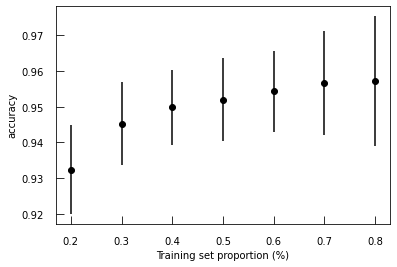

In [239]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform',n_jobs=-1)

plt.figure()

for s in t:

    scores = []
    for i in range(1,100):
        X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size = 1-s, stratify=y_cancer)
        scaler = StandardScaler() 
        scaler.fit(X_train) 

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        knn.fit(X_train_scaled, y_train)
        scores.append(knn.score(X_test_scaled, y_test))
    plt.errorbar(s, np.mean(scores),yerr=np.std(scores),c='k',marker='o')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

Of course if your training dataset is to small it is not going to be representative of the whole dataset and your accuracy on the test set is going to be small. The bigger the training set proportion is the better the chance of recapitulating the whole dataset is. But this proportion should ne be too big either because you still want an significant part of your dataset to be unseen for evaluating your model


####

Let's see how the number of neighbors actually influence the accuracy of our model. So far we just put some random values for this parameter. First with the 'uniform' voting weights:

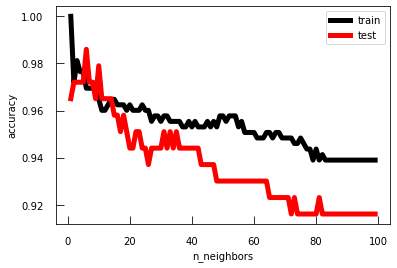

In [240]:
k_range = range(1,100)
scores_test = []
scores_train = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform',n_jobs=-1)
    knn.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(knn.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(knn.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

The train set accuracy decreases with the number of neighbors involved in the vote. For small values of n we are clearly overfitting : accuracy at one for the training set and a big drop in the accuracy of the test set.



#### Exploring and choosing in the hyperparameter space : ML routine

**If your dataset is big enough you should subdivise your training set into a true training set and what is called a validation set**. You are going to explore the hyperparameters space and optimize those hyperarameters only using the remaining training test and evaluate the choice of hyperparameters on the validation set.


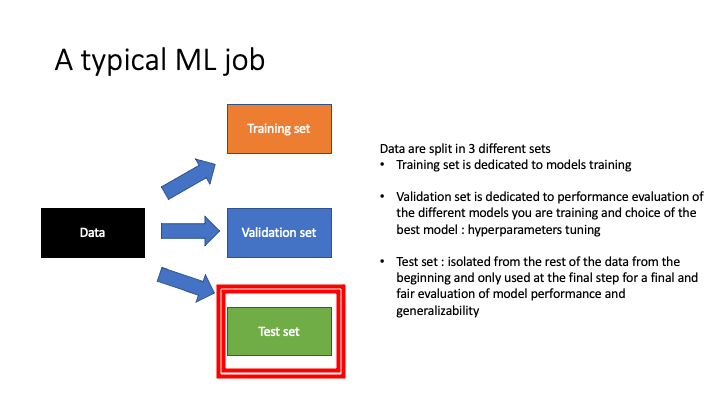

In [241]:
Image('Presentation3.png')

**If you can't afford to split again your training set, you can use Cross Validation.**

Scikit learn provides a nice built in way to vary hyperparameters and pick the best ones, through the **GridSearchCV method**.

The CV in GridSearchCV refers to Cross Validation : it means that the training data is splited multiple times between a training and validation set. Each model for which the different hyperparameters are varied is trained under a random subset of the training dataset and evaluated under the complementary subset of the training dataset. **For each hyperparameters set, this is done multiple times (typically 5 times: the training data is split in 5. 4 are used for training 1 for validation. Then you repeat 5 times so every subset has been a validation set at some point). You calculate the average score (the score can be the accuracy) from those multiple tries and take the best one.**

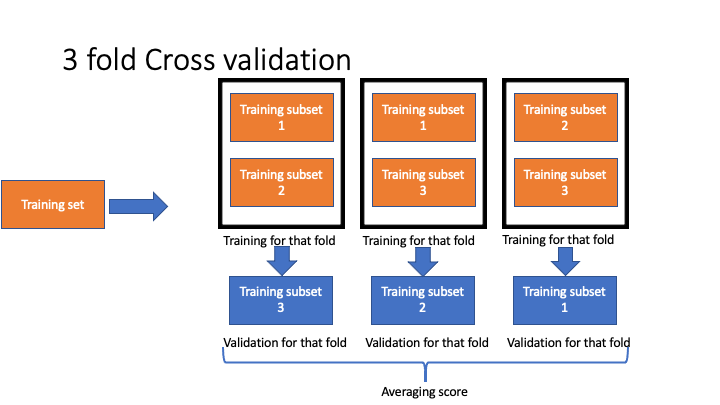

In [242]:
Image('Presentation4.png')

Just like before when we were splitting data between test and training, we have to be carefull that we don't have **data leakage between the training and validation sets**. This is why the scaling should be done on the specific subset of training for every five folds. 

**To do so we will have to create a pipeline : which is a scikit way to automatized tasks.**

In [243]:
from sklearn.pipeline import Pipeline



knn=KNeighborsClassifier(n_jobs=-1)

pipeline_knn=Pipeline([('scalar',StandardScaler()),
                     ('model',knn)])

from sklearn.model_selection import GridSearchCV


grid_values = {'model__n_neighbors': np.arange(5,50,1),'model__weights':['uniform','distance']}# define the hyperparameters you want to test
#with the range over which you want it to be tested. Notice the  double underscore? It allows to refer to a specific part of
#the pipeline, here the model.

grid_knn_acc = GridSearchCV(pipeline_knn, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be made

grid_knn_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_knn_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_knn_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_knn_acc.best_score_)#get the best score calculated from the training/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Grid best score (accuracy):  0.9647879616963065
Grid best parameter (max. accuracy) model on test:  0.972027972027972


Text(0.5, 10.0, 'Predicted label')

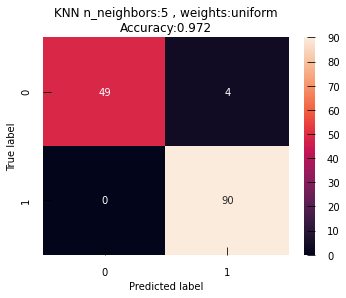

In [244]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_knn_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('KNN n_neighbors:'+str(grid_knn_acc.best_params_['model__n_neighbors'])
          +' , weights:'+grid_knn_acc.best_params_['model__weights']+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

**Congrats!!!! You just trained a classical machine learning model using best practice in term of scaling, hyperparameter choice, and data leakage.**

You just followed the routine that will be our in this whole course.

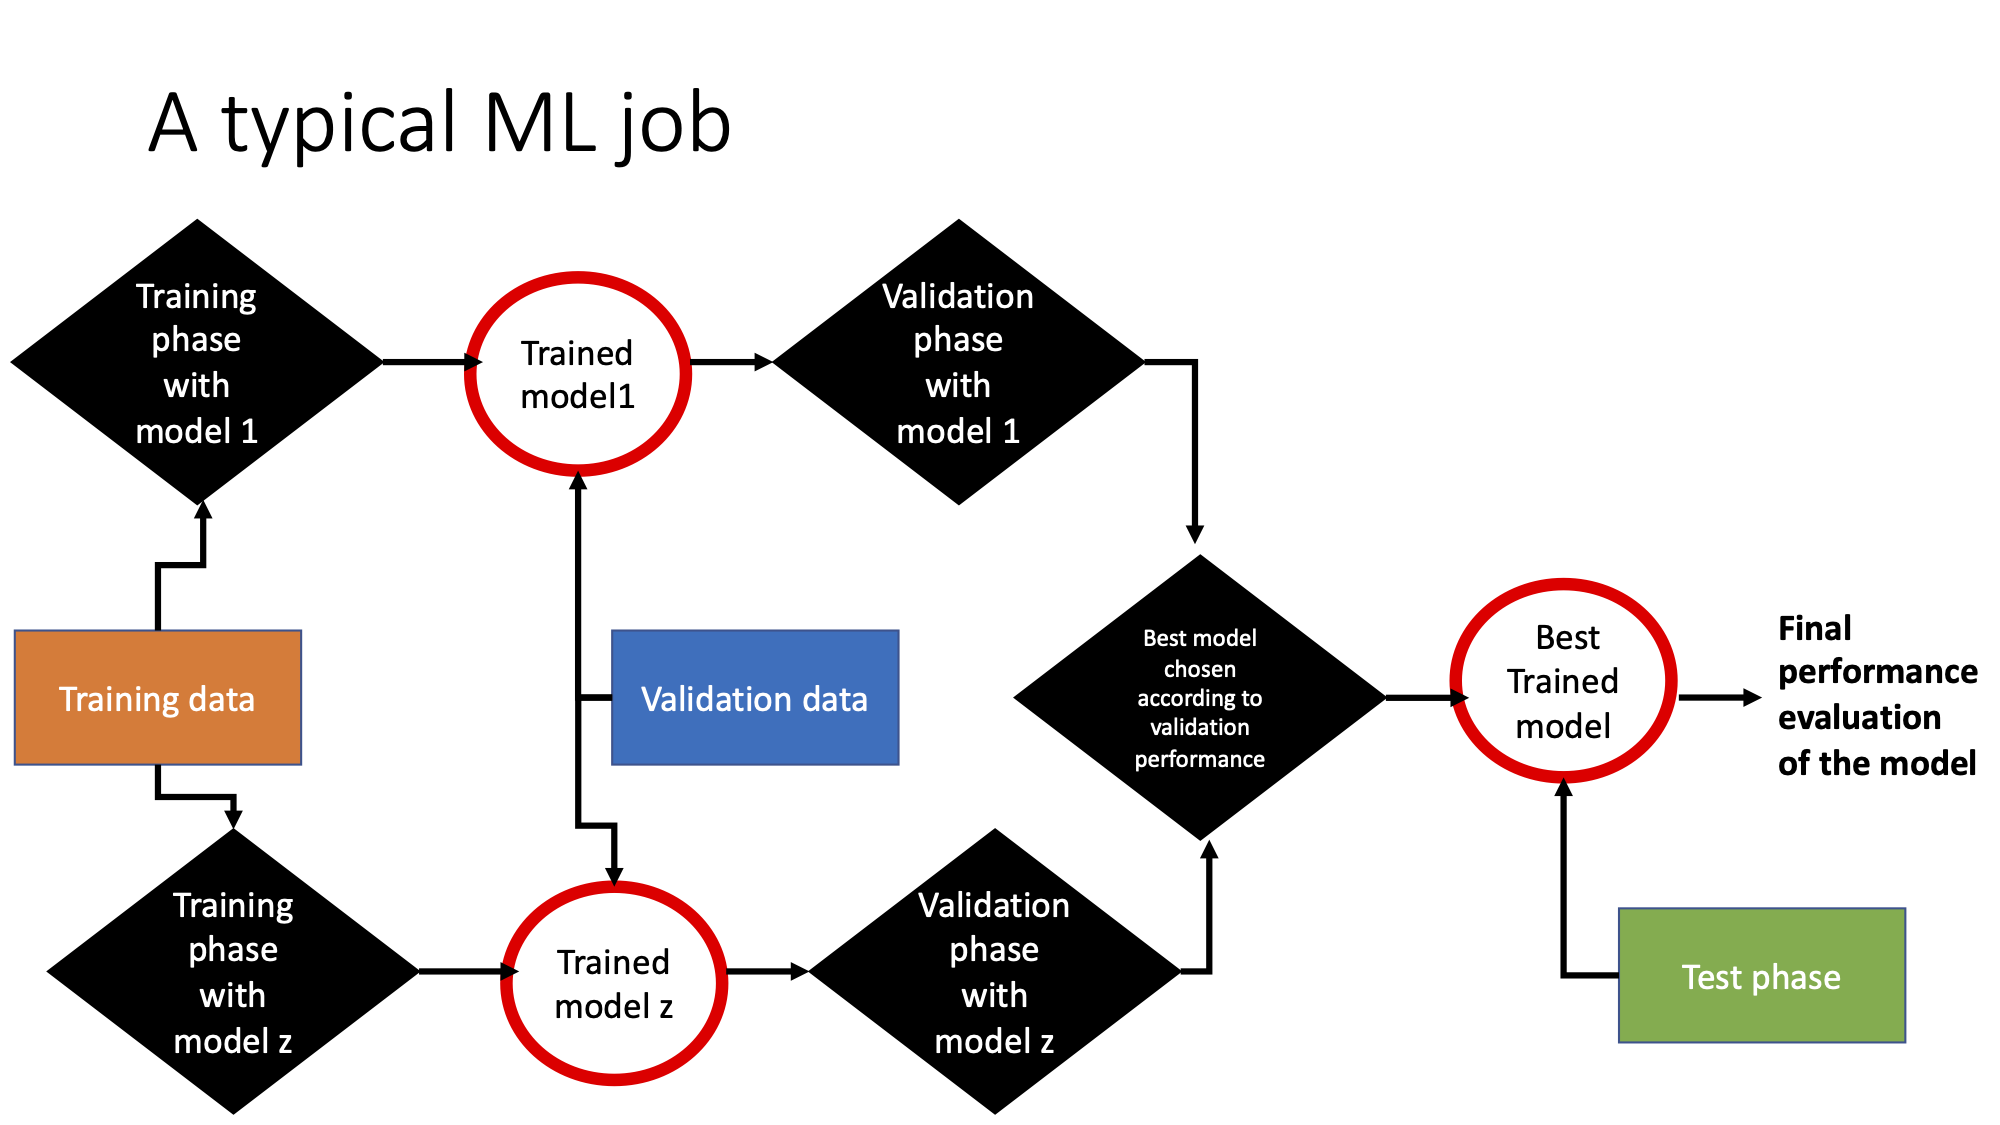

In [245]:
Image('Presentation2.png')

Now you might want to save your beautifull model so you can use it latter on , with new unknown data. For that you will need to.

Retrain your model on the full training set using the grid_knn_acc.best_params_ best hyperparamters found. 

Then **save your trained model using pickle**.

import pickle

pickle.dump(model, open(filename, 'wb'))


**if you want to load it again**

loaded_model = pickle.load(open(filename, 'rb'))

### Great we have a model but : **Was accuracy actually the metric we wanted to optimize on??**

Here we can see that eventhough our **accuracy is pretty good we are still missing 2 cancers**. In this particular case labelling a malignant tumor as begnin can have huge consequences. **The types of error are not symetrical** (we could live with predicting false positive, the patient will have to do further testing, but false negative is bad) : missing 2 malignant tumors is grave and we could try to tune our model so that it has a lower rate of false negatives even if it means that we will predict more malignant tumors when they are actually begnin and that our accuracy might decrease. 

How do we tune our model??

Well we **could use another metric for evaluation**, a metric that looks more at one particular type of error instead of global accuracy. **We could also do something that K-neighbors doesn't allow unfortunately, but that other technics make available : changing the decision threshold.**

Indeed here we don't know how indecise or precise the decision from our K-neighbors was. Maybe there was 9 voters for one class and 8 for the other, or maybe every neighbors voted for the same class. 

**Other ML algorithms allow you to have a probability attached to the choice of the class.** By default the choice is made toward a group when the propability associated with the choice is bigger than 0.5. But we can change that to be efficient at preventing one type of error. **You will see that next with ROC_AUC metric and ROC curves.**

####

**Before moving to another method let's apply what we just used to the multiclass data : Iris**. Right now you might wonder why i am introducing another dataset here. Well simply because having multi classes instead of two clasess make quite a bit of differences for the algo. It will not be obvious right now but when we will start looking into ROC_AUC, you will see what I mean. So for now let's just enjoy doing the same as before but for a multiclass dataset. 

### Iris dataset <a class="anchor" id="MC-KN"></a>

In [246]:
from sklearn.pipeline import Pipeline

X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris,
                                                   random_state=2,stratify=y_iris)

knn_i=KNeighborsClassifier(n_jobs=-1)

pipeline_knn_i=Pipeline([('scalar',StandardScaler()),
                     ('model',knn_i)])

from sklearn.model_selection import GridSearchCV


grid_values = {'model__n_neighbors': np.arange(5,50,1),'model__weights':['uniform','distance']}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_knn_i_acc_i = GridSearchCV(pipeline_knn_i, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_knn_i_acc_i.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc_i=grid_knn_i_acc_i.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_knn_i_acc_i.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_knn_i_acc_i.best_score_)#get the best score calculated from the training/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc_i)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__n_neighbors': 7, 'model__weights': 'distance'}
Grid best score (accuracy):  0.9553359683794467
Grid best parameter (max. accuracy) model on test:  1.0


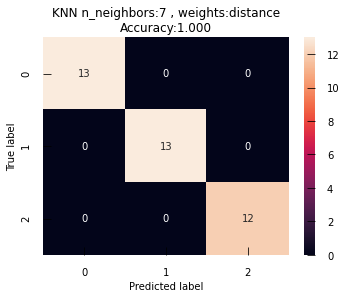

In [247]:
y_pred_test_i=grid_knn_i_acc_i.predict(X_iris_test)

confusion_mc_i = confusion_matrix(y_iris_test, y_pred_test_i)
df_im_i = pd.DataFrame(confusion_mc_i, 
                     index = [i for i in range(0,len(iris['target_names']))], columns = [i for i in range(0,len(iris['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_im_i, annot=True)
plt.title('KNN n_neighbors:'+str(grid_knn_i_acc_i.best_params_['model__n_neighbors'])
          +' , weights:'+grid_knn_i_acc_i.best_params_['model__weights']+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_iris_test, 
                                                                       y_pred_test_i)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Logistic regression <a class="anchor" id="Logistic-regression"></a>

**The main hypothesis of logistic regression is that the log odds ratio of the probability that a point is part of a certain class follows a linear combination of the features describing this point.**

Let's say you only have two classes and so your target variable can only take two values $\textbf{Y\{1,0\}}$. Let's define p=P(Y=1) the probability than your datapoint belongs to class 1. Let's also say that you have n features to describe a point $\{x_{i}\}_{i=1,n}$. And that you have m points.

Then we make the hypothesis that:

$ln{\frac{p}{1-p}}=w_{0}+\Sigma^{n}_{i=1}w_{i}x_{i}$

which translates to

$p=\frac{1}{1+e^{-(w_{0}+\Sigma^{n}_{i=1}w_{i}x_{i})}}$

**So the probability that your datapoint is in class 1 is the logisitic function (sigmoid) applied to the linear combination of features.** What you want is to **recover those sets of w that best fit your data**. You do that by using the maximum likelihood method (or minimizing the cross entropy : same as loglikelihood but with a negative sign in front of it)!

So, now the way we get the w is from fitting our distribution of probability that a point is in class 1. **To do that we maximize the likelihood of our model to generate the seen data. By doing so we might overfit on the training set. To avoid that we can disturbe a little the likelihood function so its maximum doesn't depend in an excessive way on the training set. The way to do that is to add penalty on your weights.**

You can imagine that there is a quite insignificant feature to predict which class your data belongs to. For example a feature that doesn't really describe a class, but is present for some iteration of class 1 and never present in the other classes (typically noise). But your model, if not controled for overfitting, will really try to take that feature into account because it is something that is present in one class and not in the others. To inflate that feature the model will put an overly important weight on it. To compensate you can introduce a weight penalty that if the feature is really inflated for, the maximum likelihood will not be able to compensate.

Typically in our case the new maximum likelihood function (the left hand side is the usual maximum likelihood function and the rigth hand side where you have the 1/c coefficient is the specific regularization used) that we are going to maximize is either of two (three?) forms:

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}|w_{i}|$ , l1 regularization (Lasso) C being the inverse of the weight that you put on that regularization 

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}w_{i}^{2}$ , l2 regularization (Ridge) 

$\Sigma^{m}_{k=1}log(p_{k}) - \frac{1}{C}\Sigma^{n}_{i=1}(\alpha|w_{i}|+(1-\alpha)w_{i}^{2})$ , elasticnet

For a deeper understanding of those notions :

https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

But the rule is : **when you hypothesize that you have sparse features and so you believe that among all those features only a small subset is going to be interesting (but of course you don't know which one...) then you try to use the regularization that will tend to put more of your features at the zero weight (the l1 regularization) and so reduce the complexity of your model.** This l1 norm that collapses non important features to zero is another way to do feature selection.

Finally unlike KNN you can interpret your model. The bigger the absolute value of weights associated with one feature, the more important this feature is to discriminate between your classes.


#### Toy dataset : introduction to AUC ROC <a class="anchor" id="AUC-ROC"></a>

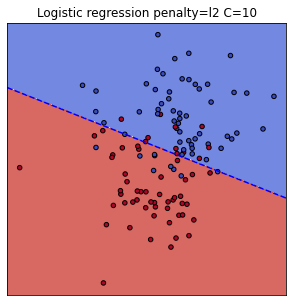

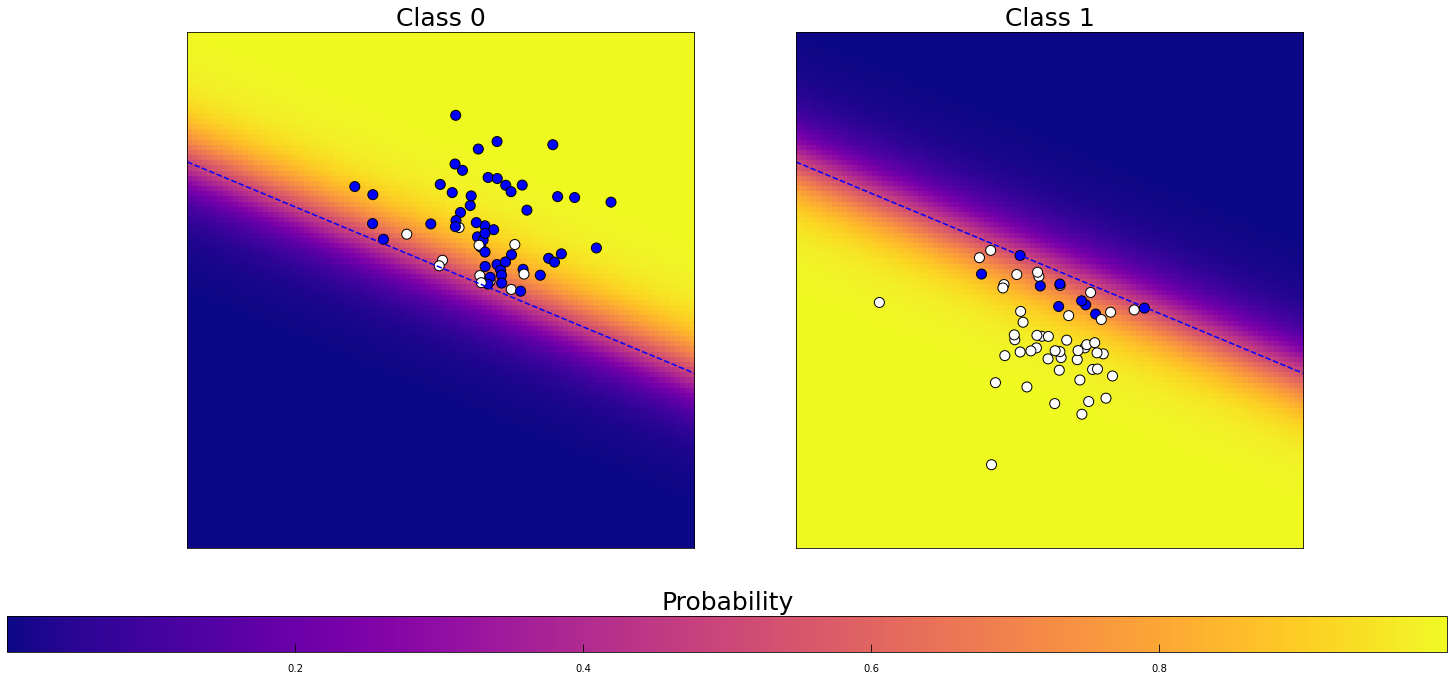

/home/seb/Documents/My_courses/crashcourseml/utils.py:245: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


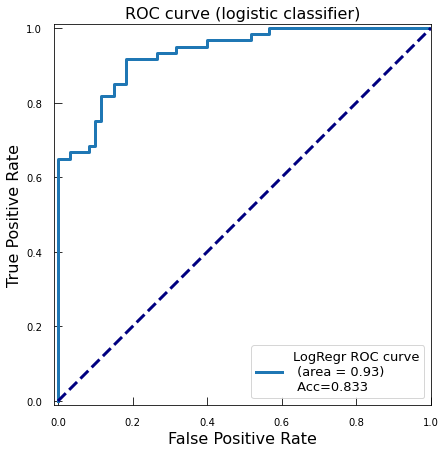

In [248]:
from utils import countour_lr
X_toy_2, y_toy_2 = make_blobs(n_samples=120, centers=2,cluster_std=3, random_state=6)

countour_lr('l2',X_toy_2, y_toy_2,10,'ovr')

From how we introduced logistic regression before you can already see that an hyperplane share the same probability. What is represented in the first panel is one particular hyperplane (here a line in dimension 2) **for which the probability to be part of one of the two groups is >0.5**. But actually that **is quite an arbitrary threshold**. The second panel of plots shows you **many of those different hyperplanes having different probabilities and you could in principle choose any of those lines for class delimitation.**

**But why would you do that? Well for example if you want to tune how stringent you want to be towards different error types.** As before, if you deal with deciding if the patient you have in front of you should go for more exams because of a suspicion of malignant tumor, you don't want to miss any of those malignant tumors. It doesn't really matter if in the process you send many clean patient for further exam. So maybe in that case having a 0.5 threshold for malignant tumor calling is too stringent.

**A way to visualize those type of problem is to look at the receiver operating curve (ROC). In this curve each point is a particular threshold and its coordinate are how much False positive and True positive this threshold will create.**

$FPR= \frac{FP}{FP+TN}$

$TPR= \frac{TP}{TP+FN}$

**Ideally you want a curve that perfectly follows the edge of the square** : whatever threshold you use you recover all the postive and the negative samples. So the best model should have an area under the curve of 1.  In reality the curve that you will get ressemble more to the one from the third panel.

There is one more thing that I would like to add here, which makes this story about ROC curve and caring about the right metric even more important. **The diagonal line in the ROC curve represents what is called a dummy classifier. It is a classifier that has learned only the probabilities to have one class instead of the other. The farther you are from that line the better you are (so the more area under the curve)**. Those comparisons to dummy classifier are really important when your dataset is imbalanced. Imagine the extreme case of a dataset made of 99 class 0 and 1 class 1. In that case your basal accuracy is going to be 98% : but that doesn't make your model good. It just means that it has chosen randomly 99 point to class as 0 and 1 to class as 1. **It is a bad model eventhough it has a high accuracy. The ROC AUC is sensitive to that**. So if you have imbalanced dataset use scoring that are sensitive to it. There are other ways to deal with it like weighting labels differently in the loss function. We will spend a little bit more time on the subject of imbalanced datasets in [Using AUC ROC to recognize artifact from unbalanced dataset](#Unbalanced), but not much. Just know that this problem exists and understand what it does through later on examples. Always check if your dataset is imbalanced or not and if it some classifier have built in functions to face that: logistic regression and SVC for example offer the use of the class_weight argument.

On the ROC curve can you find in which direction the thresholds are getting bigger?

#### Multiclass example <a class="anchor" id="MR-LR"></a>

Of course all of that can be applied to a multi-classes classification. How is it tipically done?

There are many different ways of tackling the problem, that end up being a combination of these 5 elements :

- **Either you treat the problem as one class vs one class**.

- **Or you treat the problem as a one class vs the rest : you subdivide the problem into three different problems either your are class 1 and you consider the other classes as being one big class "non 1", and you do the same for the other class**.

- **You change your loss function to a mutinomial one : softmax intead of a sigmoid.** 

In any case you need to decide **how you are going to agglomerate those different statistics (different ROC curves for example)**:

-You can either do a **micro average** where you pull all your statistics together (number of FP and so on for every sub problem) and then caluclate your statistic like the TPR


-Or you can go for a **macro average** : where you calculate the satistics for each sub problem and then do the average.



Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

Spoiler is has to do with overall separability and balance between the different class.


What strategy your logistic regression uses so you can plot the right curves, is a tricky question. For a first pass on your data always set the multiclasses method to be ovr (one vs rest) : understanding the hyperplanes relation to decision probability and the ROC curve is more intuitive that way, and I believe less sensitive to imbalance dataset.

All the ROC curve below are OnevsRest unless specified.

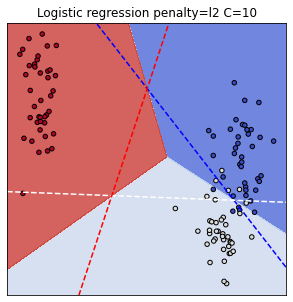

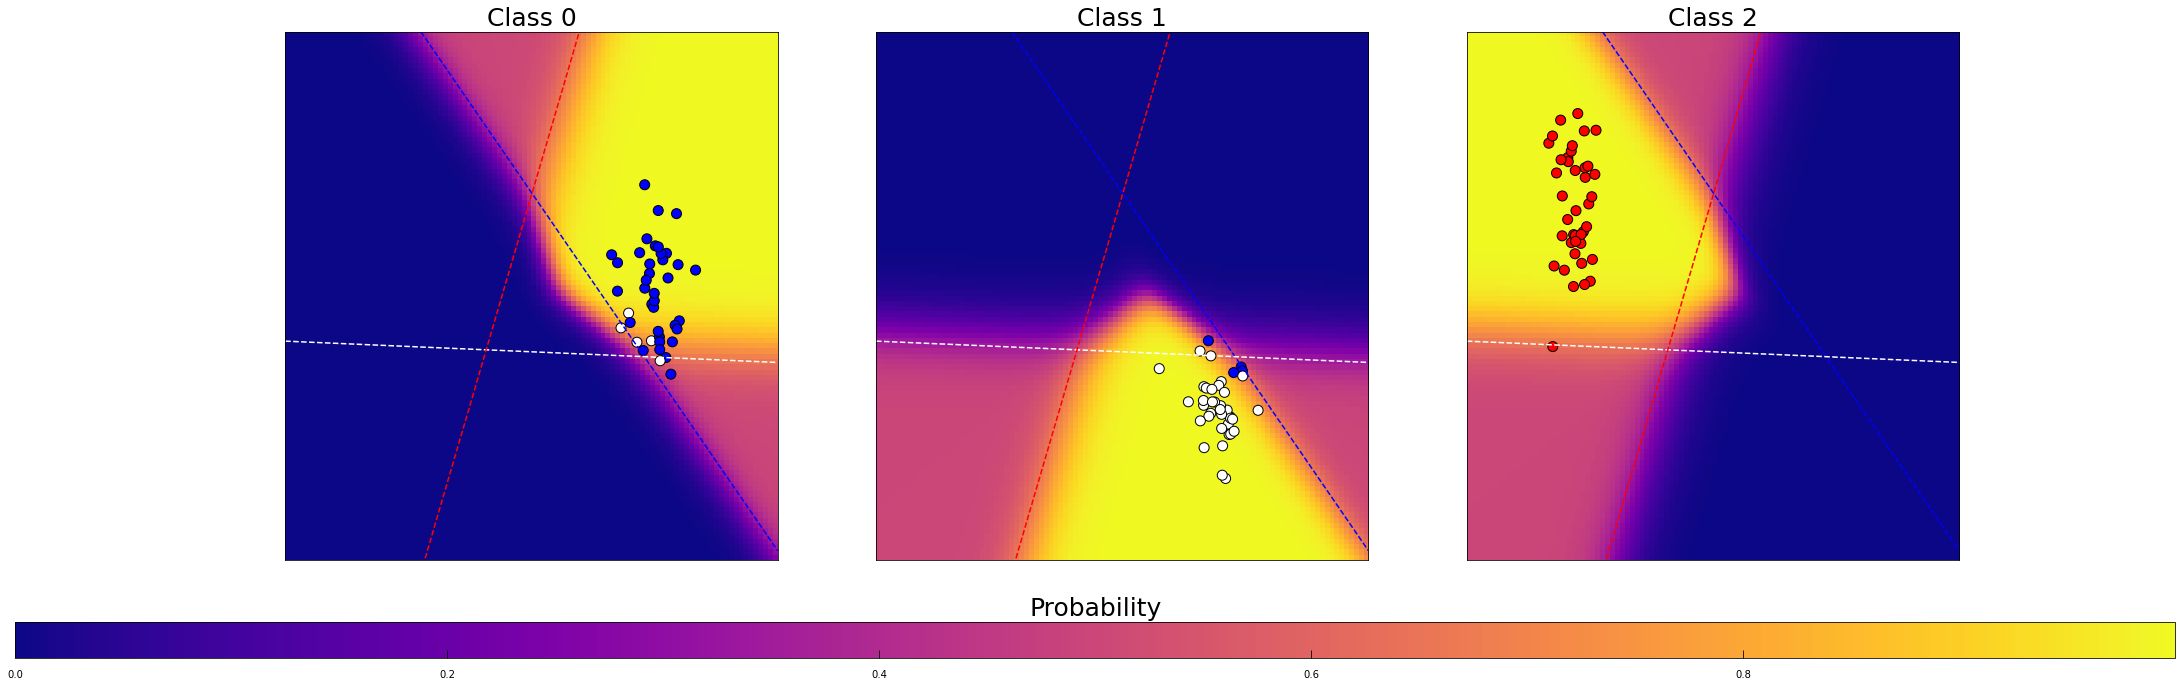

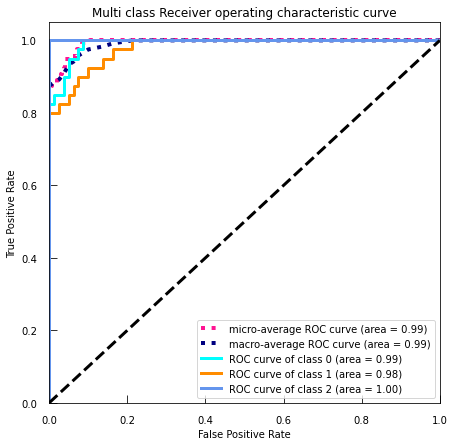

In [249]:
#one vs rest implementation
countour_lr('l2',X_3,y_3,10,'ovr')

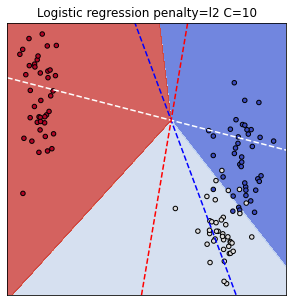

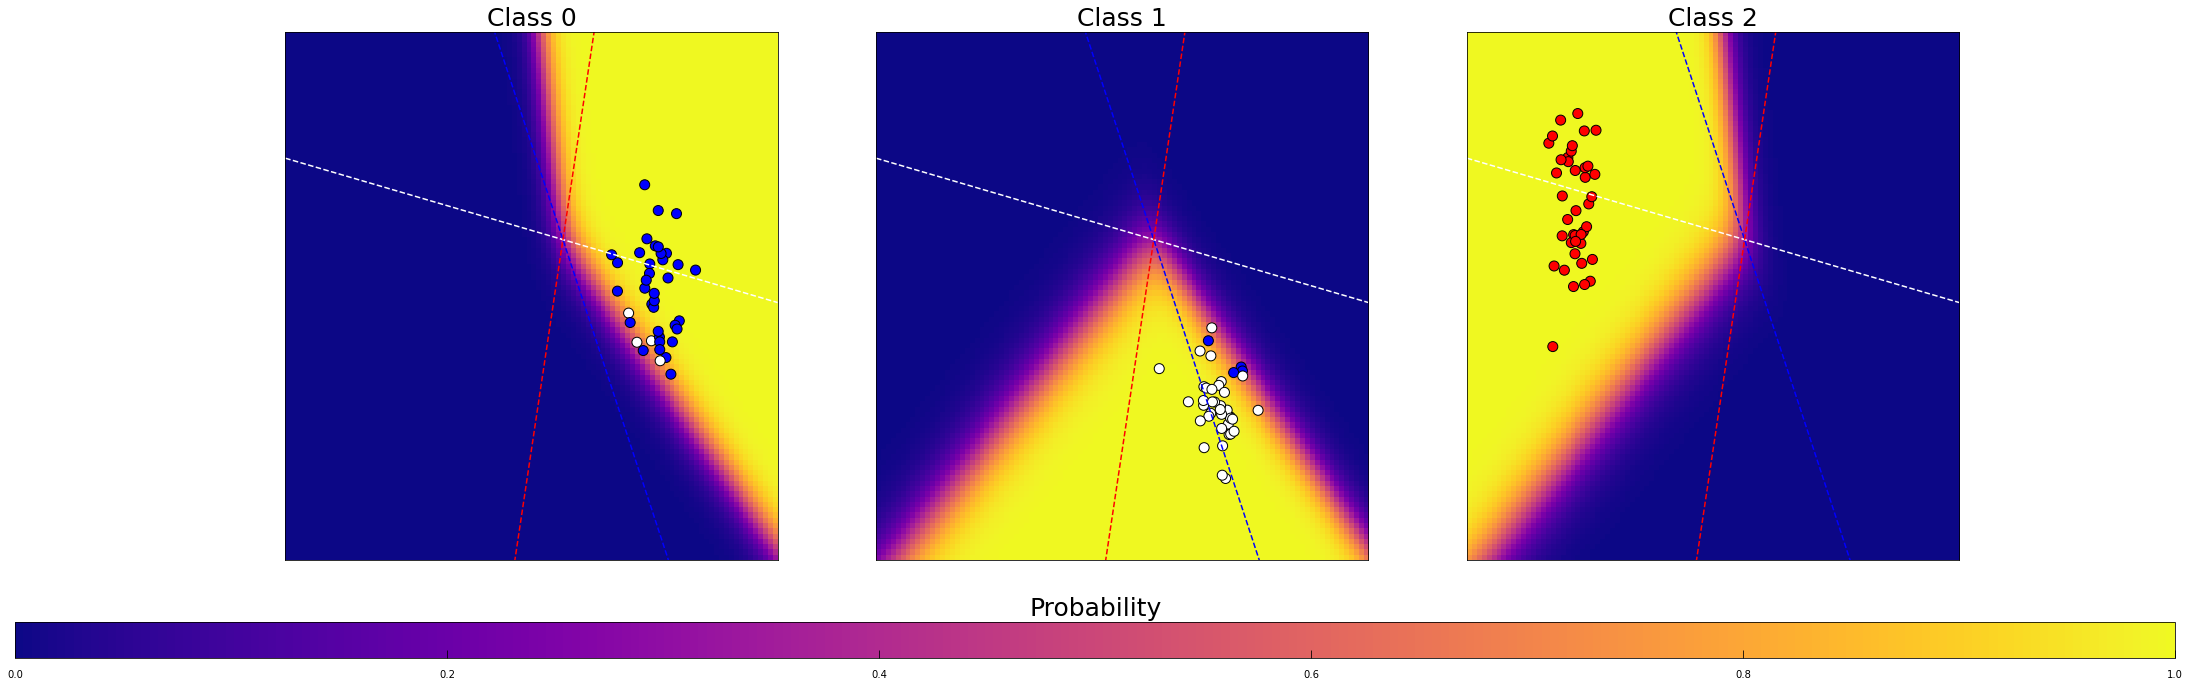

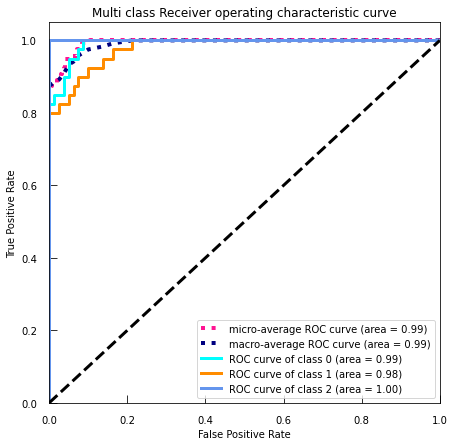

In [250]:
#Multinomial implementation : the boundaries are less interpretable
countour_lr('l2',X_3,y_3,10,'multinomial')

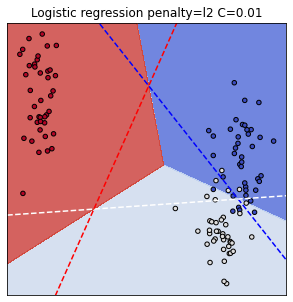

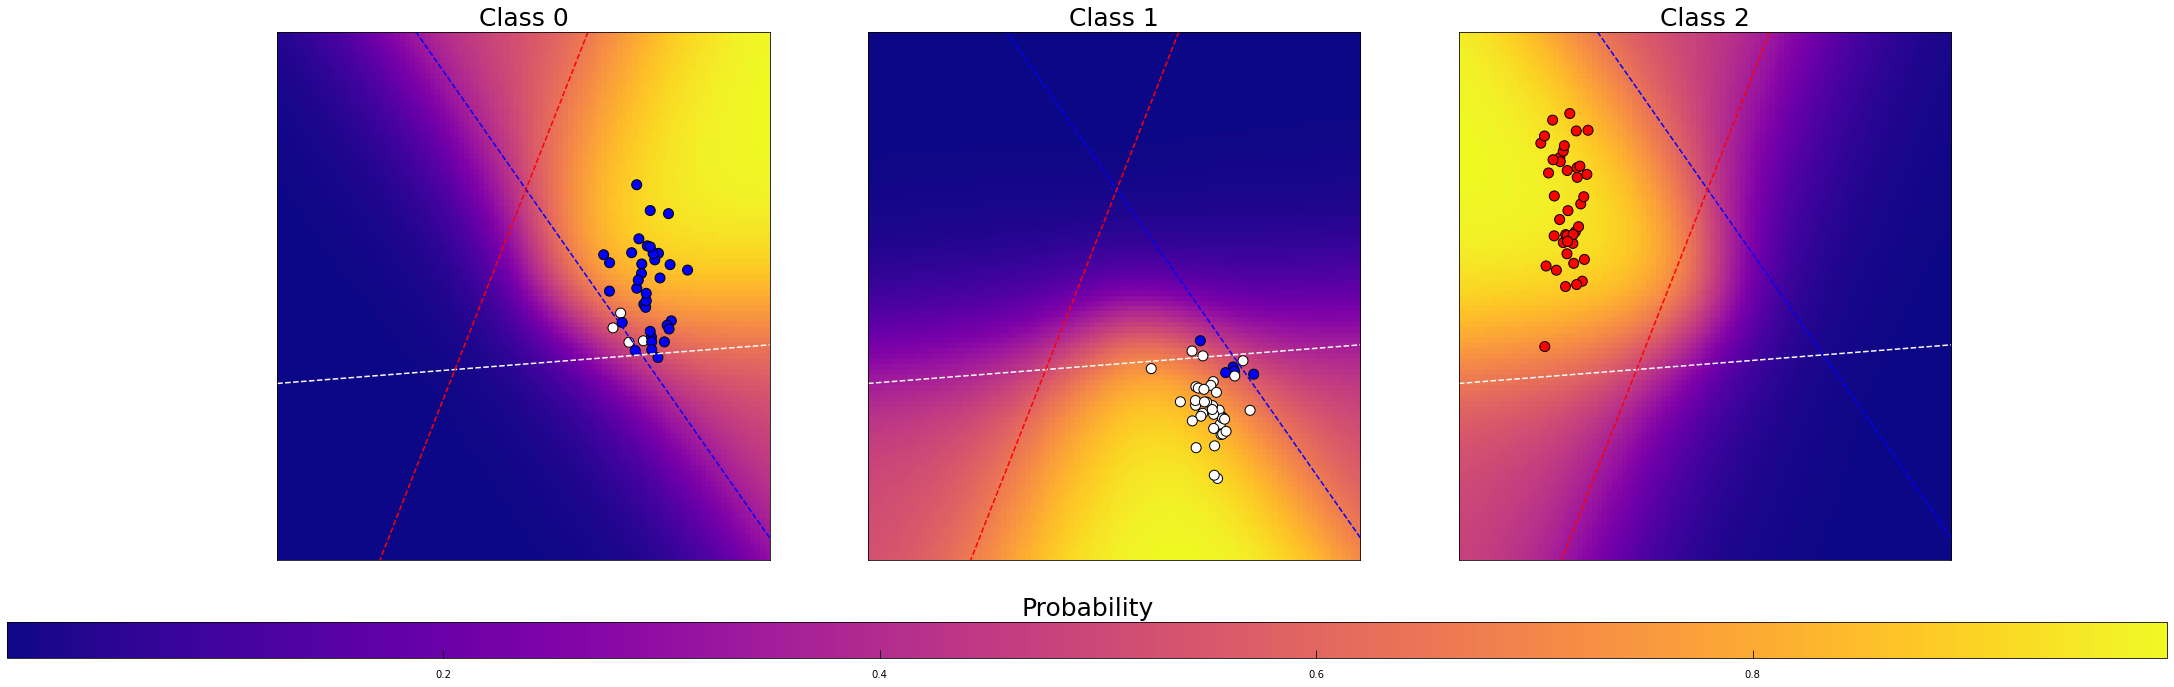

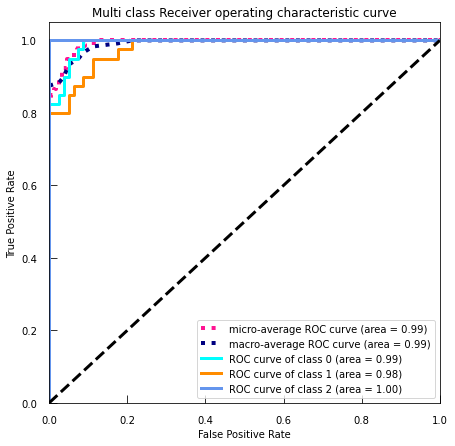

In [251]:
countour_lr('l2',X_3,y_3,10**-2,'ovr')

In the above I added quite a lot a l2 regularization, notice how the boundaries are fusier?

### Small aparte on imbalanced dataset and dummy classifier <a class="anchor" id="Unbalanced"></a>

In [252]:
X2_i, y2_i = make_blobs(n_samples=(500,50), centers=[[1,1],[1,1]], random_state=6)

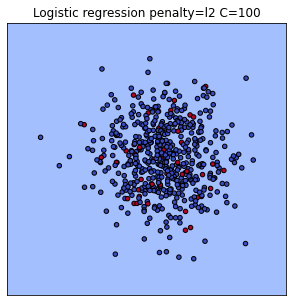

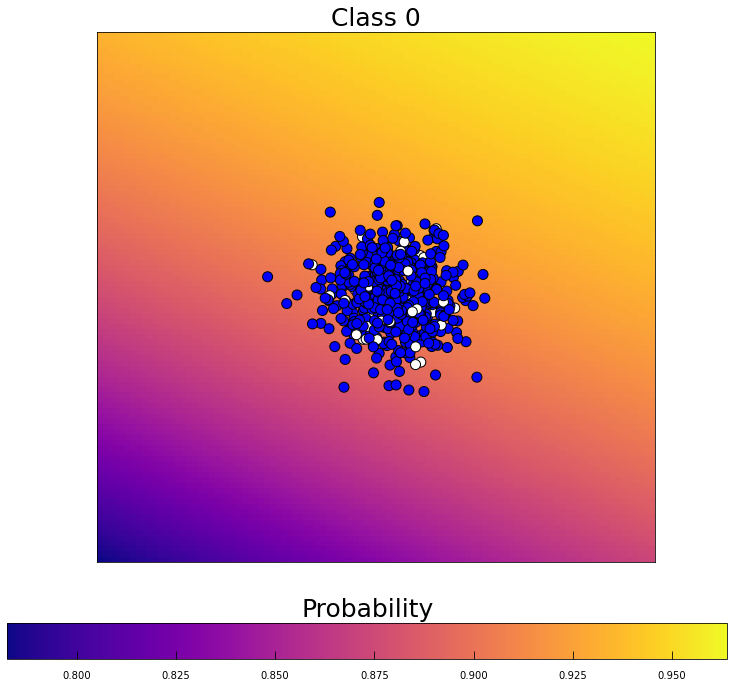

/home/seb/Documents/My_courses/crashcourseml/utils.py:245: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


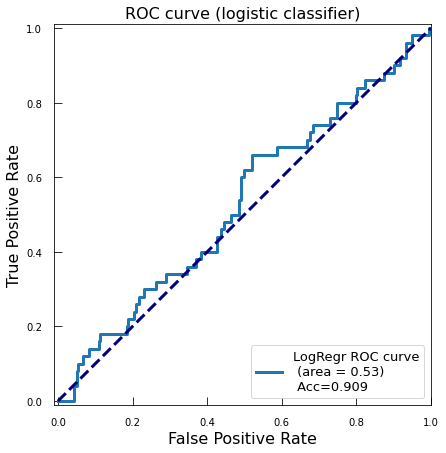

In [253]:
countour_lr('l2',X2_i,y2_i,100,'ovr')

**As you can see here the data was not separable from the beginning**. But just because the dataset was imbalanced (500 of one class and only 50 of the other) and we trained our model on accuracy score **we still get a good accuracy**. But this is missleading, our model is not usefull right now, it is randomly assigning labels according to the statistics of the labels. Again, accuracy is informative but doesn't hold all the information.

Also, because of how this metric is built it gives the same importance in its calculation to both classes. I fyou would like to focus on your ability to detect class 1 rather than 0 use the precision recal curve :

Precision : $\frac{\bf{TP}}{\bf{TP}+\bf{FP}}$

Recall : $\frac{\bf{TP}}{\bf{TP}+\bf{FN}}$

You will see how it looks in the following paragraphes, just remember that just like before this method estimate statistics (here precision and recall) over different decision threshold. You can summurize the goodness of the model with one number just like before : the average precision. We will see that later on 


If you don't feel like going through different scoring (i.e. accuracy), you can compare your model to a dummy classifier that will either only learn the statistic of your training set or always answer the most probable class (other dummy classifier are available): sklearn.dummy.DummyClassifier

### Breast cancer dataset  <a class="anchor" id="LR-hyper"></a>

In [254]:
lr = LogisticRegression(penalty='l2',C=10)
lr.fit(X_cancer_train_scaled, y_cancer_train)

y_pred_test_scaled=lr.predict(X_cancer_test_scaled)

y_pred_train_scaled=lr.predict(X_cancer_train_scaled)


print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(lr.score(X_cancer_train_scaled,y_cancer_train),\
                                                           lr.score(X_cancer_test_scaled,y_cancer_test)))




Acc= 0.991 on scaled train, Acc= 0.972 on scaled test


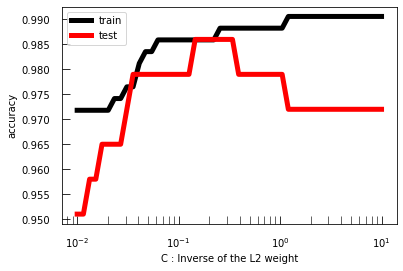

In [255]:
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l2',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L2 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

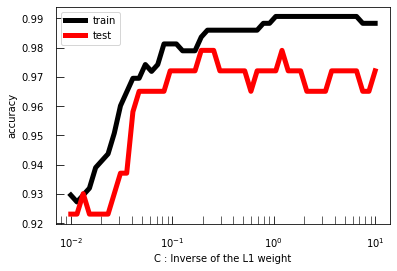

In [256]:
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l1',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L1 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

Whatever the penalty norm is, we observe the same thing. **Train and test accuracy increase together with the inverse of the norm weight: starting from too much regularization we are not actually fitting our data at first.... At some point we see the overfitting rising: test accuracy drops while train accuracy flatten at a perfect 1. This makes sense: we add a penalty to avoid overfitting and going to the right side of the graph we reduce this counter measure. We can see here that there is indeed an optimal value, in between of those two extremes, for the strenght of our regularization.**

That penalty is tuned by the type of norm we are using but also by a scalar. Here we represent the scalar by its inverse... So the more we go on the right side of the plot the less we counter overfitting. But if we are too much on the left side of plot then the penalty is too big and it becomes difficult to fit our data! 

In [257]:
logi_r=LogisticRegression(n_jobs=-1)

pipeline_lr=Pipeline([('scalar',StandardScaler()),
                     ('model',logi_r)])

from sklearn.model_selection import GridSearchCV


grid_values = {'model__C': np.logspace(-2,1,50),'model__penalty':['l1','l2'],'model__solver':['liblinear']}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score(here accuracy) over which the decision should be taken

grid_lr_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_lr_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__C': 0.16768329368110083, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Grid best score (accuracy):  0.9835567715458277
Grid best parameter (max. accuracy) model on test:  0.986013986013986


/home/seb/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Text(0.5, 10.0, 'Predicted label')

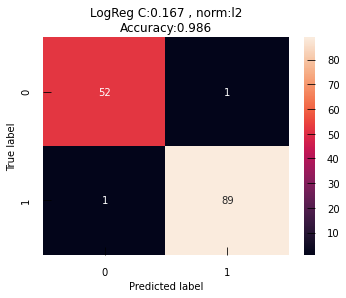

In [258]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
y_pred_test_c=grid_lr_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)
df_cm_c = pd.DataFrame(confusion_mc_c, 
                     index = [i for i in range(0,len(cancer['target_names']))], columns = [i for i in range(0,len(cancer['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_c, annot=True)
plt.title('LogReg C:'+str(grid_lr_acc.best_params_['model__C'])[:5]
          +' , norm:'+grid_lr_acc.best_params_['model__penalty']+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_cancer_test, 
                                                                       y_pred_test_c)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

Let's check how the model actually discriminates the two classes with the code below. Or said differently : what can we learn from our model a part from pure classification.

In [259]:
from operator import itemgetter
lr = LogisticRegression(penalty=grid_lr_acc.best_params_['model__penalty'],C=grid_lr_acc.best_params_['model__C'],
                       solver=grid_lr_acc.best_params_['model__solver'])
lr.fit(X_cancer_train_scaled, y_cancer_train)
w=lr.coef_[0]#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,worst texture,0.630225
1,worst area,0.572911
2,worst radius,0.570279
3,worst concave points,0.542820
4,radius error,0.538179
5,worst perimeter,0.506314
6,worst symmetry,0.501183
7,area error,0.468761
8,mean concave points,0.464202
9,worst concavity,0.447585


<ipython-input-260-4a8e7adf729e>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


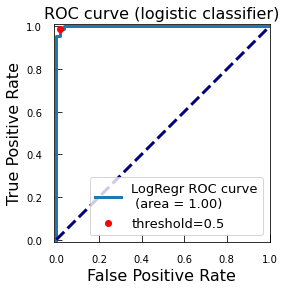

In [260]:
import scipy as sc
# this three lines here are how you get the area under the ROC curve score which is very important for evaluating your model
y_score_lr_c = grid_lr_acc.decision_function(X_cancer_test)#decision_function gives you the proba for a point to be in
# a class
fpr_lr_c, tpr_lr_c, thre = roc_curve(y_cancer_test, y_score_lr_c)# this calculates the ROC curve
roc_auc_lr_c = auc(fpr_lr_c, tpr_lr_c)#finally this calculates the area under the curve

proba=sc.special.expit(thre)
for i in range(len(proba)):
    if abs(proba[i]-0.5)<0.1:
        keep=i
        break
        

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_c, tpr_lr_c, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc_lr_c))
plt.plot(fpr_lr_c[keep], tpr_lr_c[keep],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

From the plot above we see that putting our decision threshold to 0.5 to discriminate between cancer and non cancer lead to missing 2 or 3 % of the cancer. **So maybe a better threshold should be a lower one that will put our red dot on the right side of the curve, optimally exactly were you have a TPR of one and a FPR around 0.15.**

Scikit learn allows you to directly plot those curves 

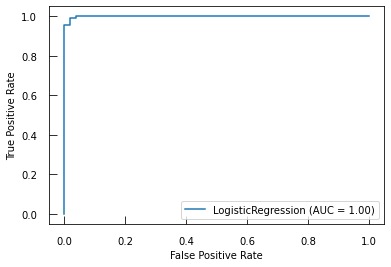

In [261]:
y_score_lr_c = lr.decision_function(X_cancer_test_scaled)
plot_roc_curve(lr,X_cancer_test_scaled, y_cancer_test)

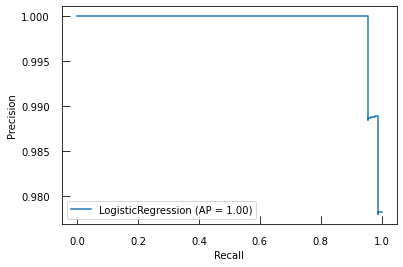

In [262]:
#Precision recall curve : AP = Average Precision
y_score_lr_c = lr.decision_function(X_cancer_test_scaled)
plot_precision_recall_curve(lr,X_cancer_test_scaled, y_cancer_test)

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $R_n$ is recall at threshold n and $P_n$ is precision at threshold n

So AP (Avergae precision) is the weighted average over all the threshold of the precision relative to the difference of recall between two thresholds

Or you can code it yourself

<ipython-input-263-e2afb75ef553>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


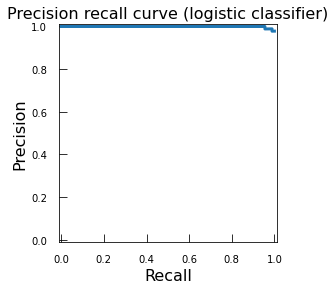

In [263]:
y_score_lr_c = grid_lr_acc.decision_function(X_cancer_test)#decision_function gives you the proba for a point to be in
# a class
prec_lr_c, rec_lr_c, thre = precision_recall_curve(y_cancer_test, y_score_lr_c)# this calculates the ROC curve


        

plt.figure()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(rec_lr_c, prec_lr_c, lw=3)

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision recall curve (logistic classifier)', fontsize=16)


plt.axes().set_aspect('equal')
plt.show()

In [264]:
# Those are the other scores (other than accuracy and roc_auc) to evaluate the performence of your model.
#If you recall we used scoring=accuracy in our GridSearchCV. But we could use another metric.

from sklearn.metrics.scorer import SCORERS
for i in sorted(list(SCORERS.keys())):
    print(i)

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_root_mean_squared_error
normalized_mutual_info_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
v_measure_score


## Iris data_set <a class="anchor" id="LR-IRIS"></a>

Grid best parameter (max. accuracy):  {'model__C': 3.727593720314938, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Grid best score (accuracy):  0.9375494071146246
Grid best parameter (max. accuracy) model on test:  1.0


/home/seb/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


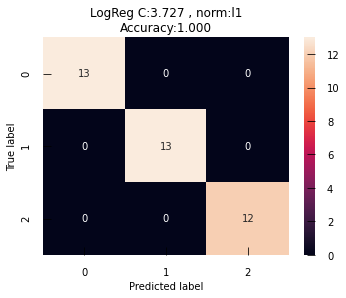

In [265]:
grid_values = {'model__C': np.logspace(-2,1,50),'model__penalty':['l1','l2'],'model__solver':['liblinear']}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc_i = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_lr_acc_i.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc_i=grid_lr_acc_i.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_lr_acc_i.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc_i.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc_i)# get the equivalent score on the test
#dataset : again this is the important metric


y_pred_test_i=grid_lr_acc_i.predict(X_iris_test)

confusion_mc_i = confusion_matrix(y_iris_test, y_pred_test_i)
df_cm_i = pd.DataFrame(confusion_mc_i, 
                     index = [i for i in range(0,len(iris['target_names']))], columns = [i for i in range(0,len(iris['target_names']))])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm_i, annot=True)
plt.title('LogReg C:'+str(grid_lr_acc_i.best_params_['model__C'])[:5]
          +' , norm:'+grid_lr_acc_i.best_params_['model__penalty']+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_iris_test, 
                                                                       y_pred_test_i)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [266]:
scaler = StandardScaler() 
scaler.fit(X_iris_train)# the scaler is fit only on the train data!!!!!!!! 

X_iris_train_scaled = scaler.transform(X_iris_train)# you should always rescaled data after the splitting, 
X_iris_test_scaled = scaler.transform(X_iris_test)

lr = LogisticRegression(penalty=grid_lr_acc_i.best_params_['model__penalty'],C=grid_lr_acc_i.best_params_['model__C'],
                       solver=grid_lr_acc_i.best_params_['model__solver'],n_jobs=-1)
lr.fit(X_iris_train_scaled, y_iris_train)
w=lr.coef_[0]#get the weights

sorted_features=sorted([[iris['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


/home/seb/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


,feature,abs contribution to the model
0,petal length (cm),4.100465
1,petal width (cm),1.670267
2,sepal width (cm),1.371040
3,sepal length (cm),0.000000


Do you think this is in line with what we saw in the PCA?

####


Before moving to SVM, let's see how the different way to apply ROC_AUC in the context of multiclass is actually different. You will see that eventhough it leads to quite different curve since the data is somehow nice in term of balance and separability, the overall conclusion and choice of threshold is not "too much" impacted (big quotation mark here :-)).

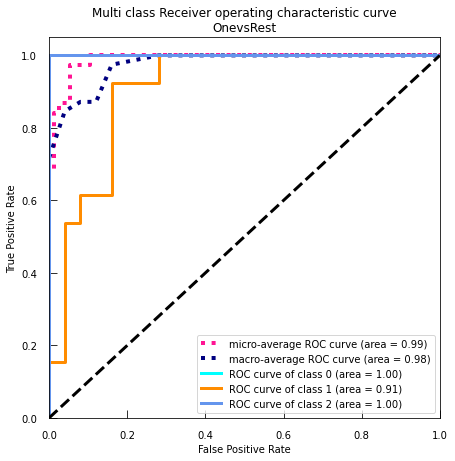

In [267]:
from utils import roc_multi_ovr
roc_multi_ovr(grid_lr_acc_i,3,X_iris_train, y_iris_train,X_iris_test, y_iris_test)

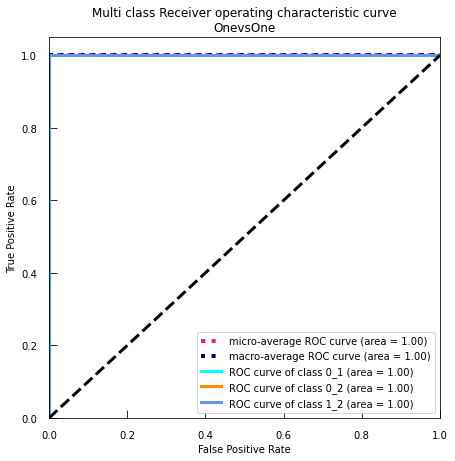

In [268]:
from utils import roc_multi_ovo
roc_multi_ovo(grid_lr_acc_i,3,X_iris_train, y_iris_train,X_iris_test, y_iris_test)

# Support Vector Machine (SVM) <a class="anchor" id="SVM"></a>

The basic principle of SVM is pretty simple. SVM aims at finding the 'good' threshold (hyperplane) to separate data from different classes. Conceptually it is very different from logistic regression where you maximize the log likelihood of the log odds function. **With SVM you really look for an hyperplane that separates data and that's it : there is no underlying hypothesis about proability distribution or anything else. It is very geometrical.**

So what's a good threshold? Again it is going to depend on the metric you are interested in. But at least a good threshold should be linked to this biais variance trade off in the sens that it should offer flexibility to your model.

You can imagine that there is a quite a lot of hyperplanes separating data in your training set. You could stick your threshold right where the class 0 point closest to class 1 lies. But in that case it will be very far from the other class 0 points, which can be a problem. **You could decide that your threshold should be right between the two closest extreme of your classes but that is going to be very sensitive to missclassified data or extreme events... Those points choosen as a reference to put your threshold are called support vectors.** 



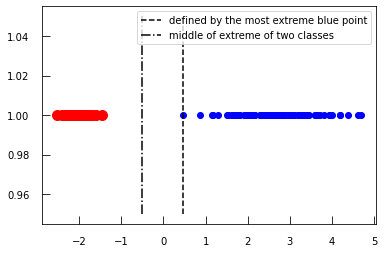

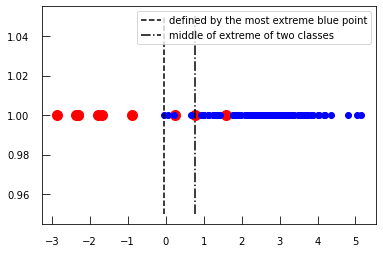

In [269]:
np.random.seed(10815657)
norm1=0.2*np.random.randn(100)-2
norm2=0.8*np.random.randn(100)+2.5
plt.plot(norm1,[1 for i in range(100)],'ro',markersize=10)
plt.plot(norm2,[1 for i in range(100)],'bo')
s_2=sorted(norm2)
s_1=sorted(norm1)
plt.plot([s_2[0],s_2[0]],[0.95,1.05],'k--',label='defined by the most extreme blue point')
plt.plot([(s_2[0]-s_1[-1])/2+s_1[-1],(s_2[0]-s_1[-1])/2+s_1[-1]],[0.95,1.05],'k-.',label='middle of extreme of two classes')
plt.legend(loc='best')
plt.show()

cauch=0.8*np.random.standard_cauchy(10)-2
norm=1*np.random.randn(100)+2.5

plt.plot(cauch,[1 for i in range(10)],'ro',markersize=10)
plt.plot(norm,[1 for i in range(100)],'bo')
sort_c=sorted(cauch)
sort_n=sorted(norm)

plt.plot([sort_n[0],sort_n[0]],[0.95,1.05],'k--',label='defined by the most extreme blue point')
plt.plot([(sort_n[0]-sort_c[-1])/2+sort_c[-1],(sort_n[0]-sort_c[-1])/2+sort_c[-1]],[0.95,1.05],'k-.',label='middle of extreme of two classes')
plt.legend(loc='best')

plt.show()

So, once again, you are confronted to a compromise. You should place your threshold somwhere that is globally best even though that would mean some miss-classification. We are back to our regularization problem and of course **Support vector machine has a regularization parameter : C**. The game now becomes placing your threshold right in the middle of points (support vectors) from  each classes that you have "chosen" to be general points for decision making : **they don't need to be the two closest points from different classes anymore. They need to be points where your hyperplane makes the least error differantiating classes.**

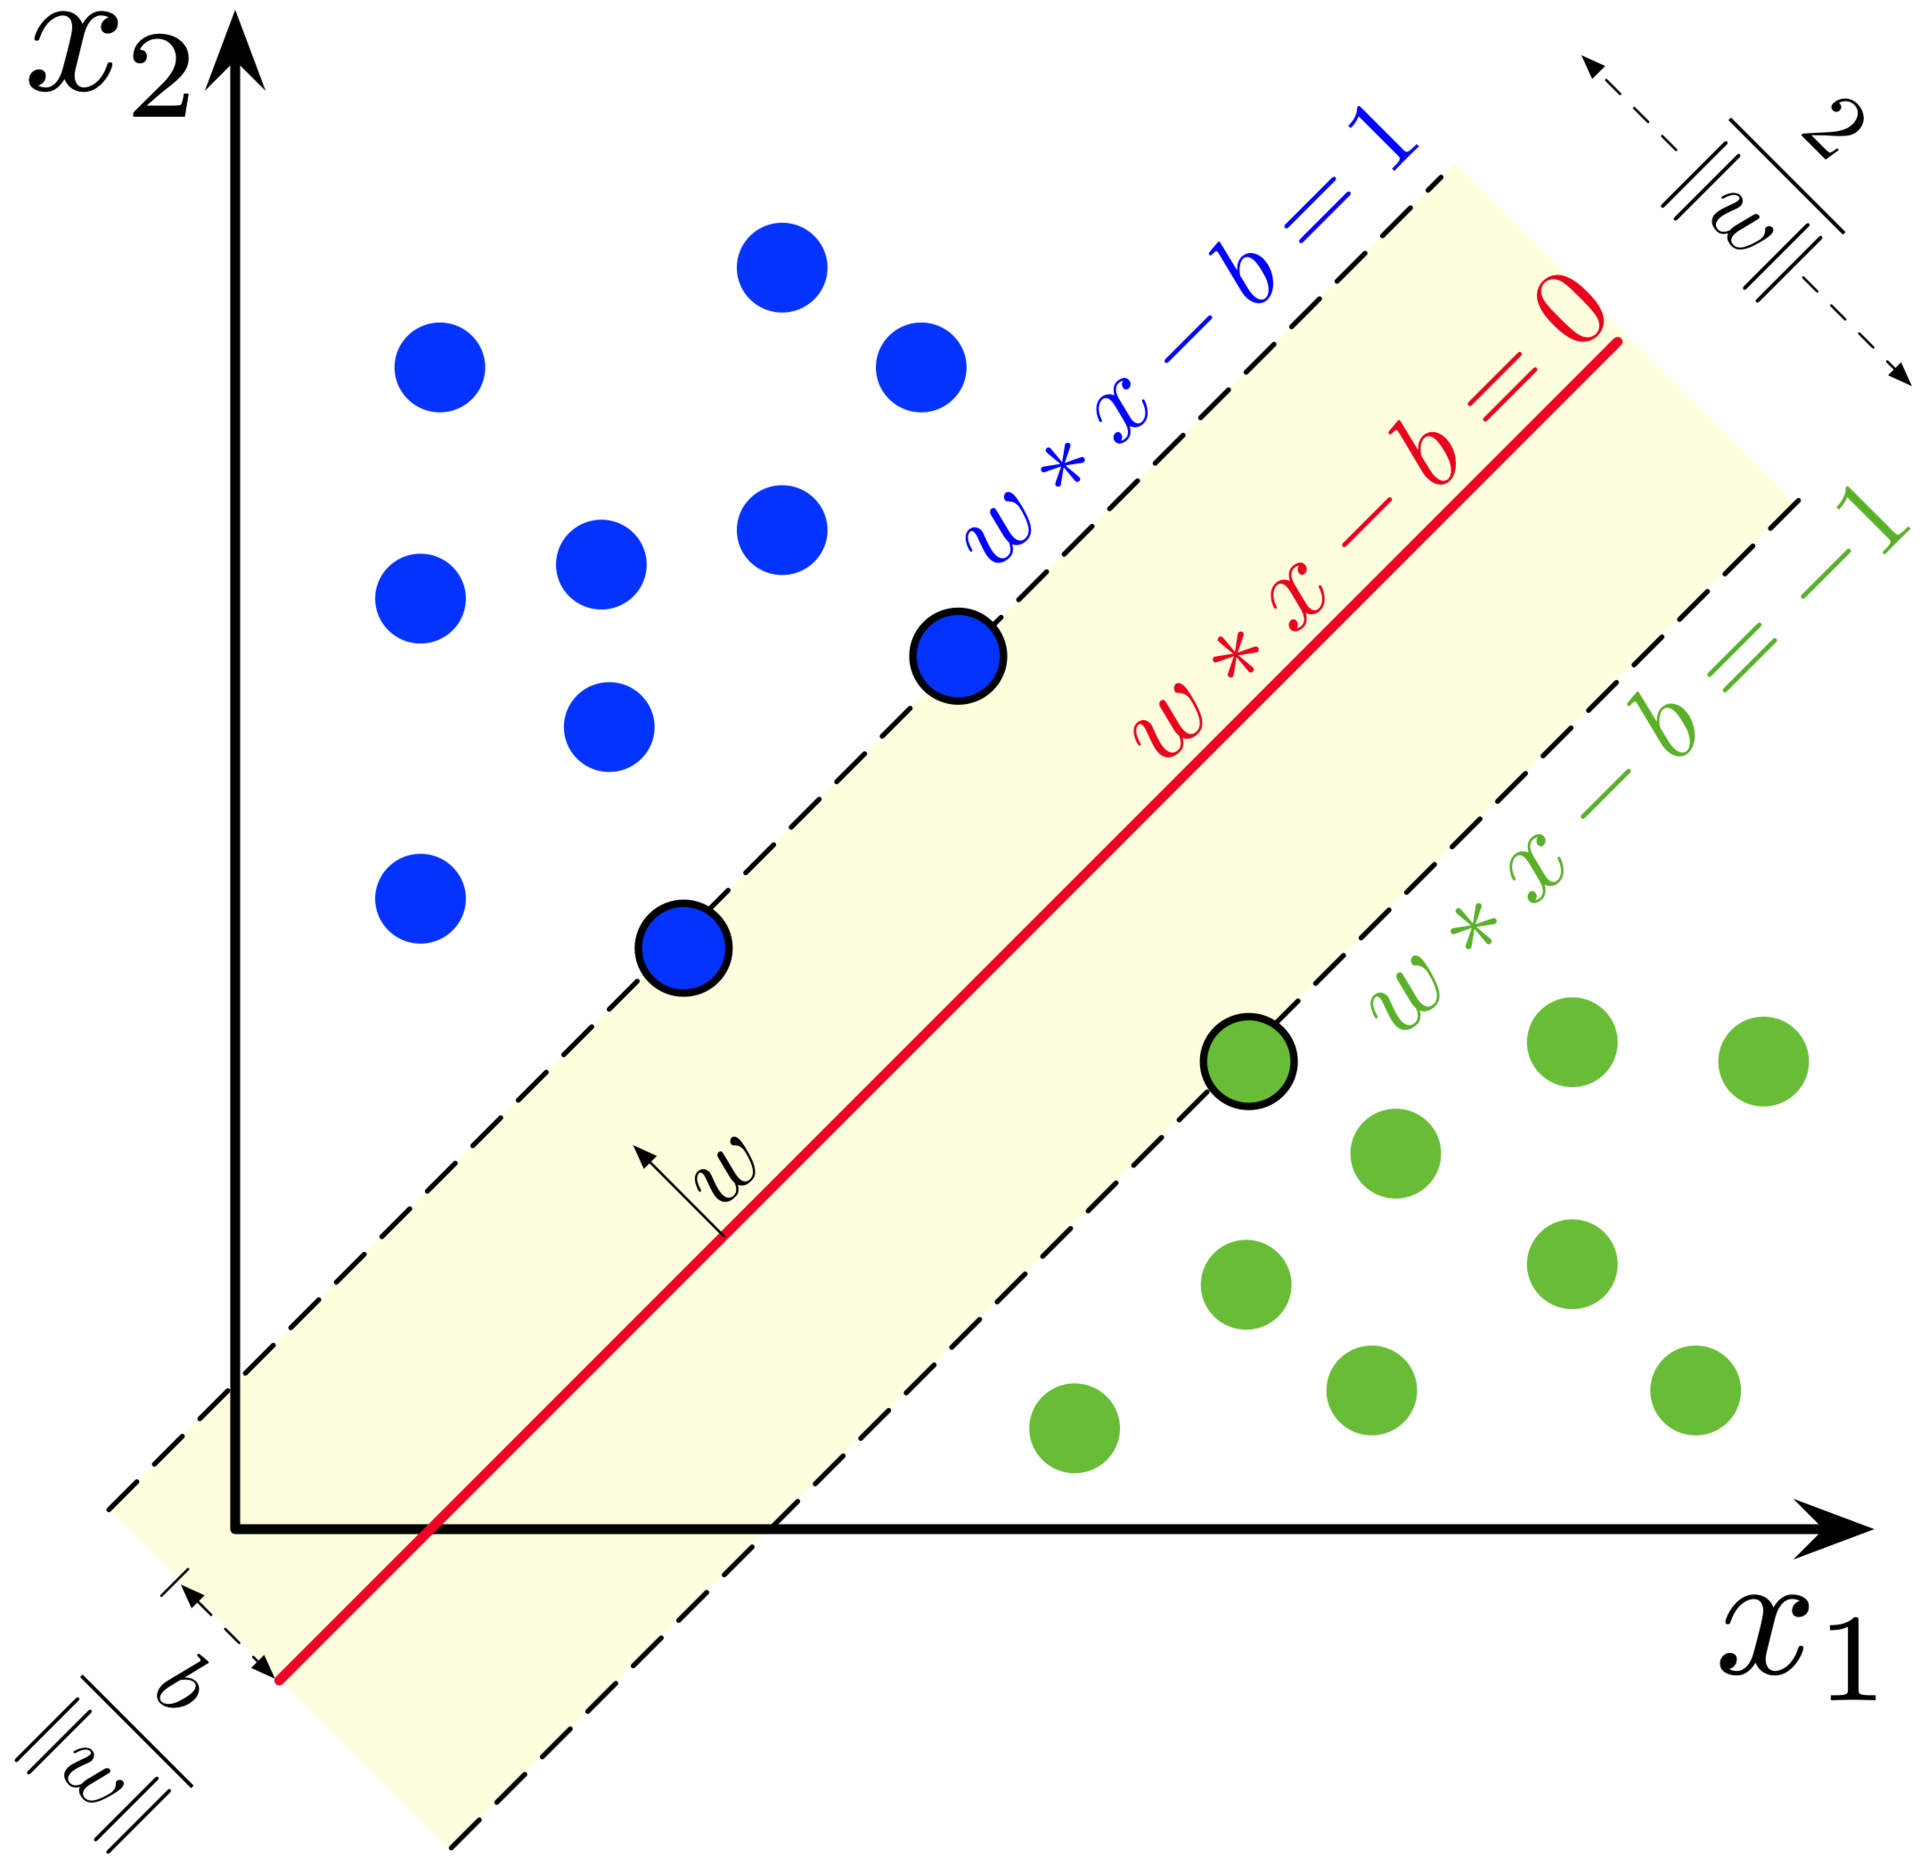

In [270]:
Image('SVM_margin.png')

Image source : image by wikipedia user Larhmam, distributed under a [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/deed.en).

You can see that there is a [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is juste the cartesian dot product that you probably use all the time. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes. But you might be familiar with other scalar product : like for example when you proceed to a Fourier decomposition of a function. This particular scalar product acts on functions and so is not really of interest for us... But others exist.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\overrightarrow{x_{i}}.\overrightarrow{x_{j}}$ : cartesian

$(\overrightarrow{x_{i}}.\overrightarrow{x_{j}})^{d}$ : polynomial degree d

$exp(-\gamma||\overrightarrow{x_{i}}-\overrightarrow{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\overrightarrow{x_{i}}.\overrightarrow{x_{j}}+c)$ : hyperbolic tangent

**This is really powerful for classification but going non-linear by using a kernel trick prevents you to interpret how your features are massaged to create this classifier... So if you want interpretability and do science rather than engineering keep it linear.**

Finally let's look at the analysis part of the problem : what is our loss function here ? (what do we want to optimize over? Remember for the logistic regression we were maximizing likelihood.)

You want to maximize the distance between your hyperplane and your support vectors. This distance is $\frac{2}{||\overrightarrow{w}||}$. So you want to minimize $||\overrightarrow{w}||$. 

So you want to minimize $||\overrightarrow{w}||$ with the constraint that most of the points on each side of the hyperplane belong to the same class. This translates into minimizing what is called a hinge loss :

$\frac{1}{m}\Sigma^{m}_{k=1}max(0,1-y_{k}(w^{T}x_{k}-b)) - \frac{1}{C}\Sigma^{n}_{i=1}||w_{i}||^{2}$

, where 
 * $y_k$ is $-1$ or $1$ depending on the class of the point $k$
 * the class of point $x_k$ is determined by the SVM using the sign of $(w^{T}x_{k}-b)$ (ie, on which side of the $(w^{T}x_{k}-b)=0$ hyperplane we are).


Note that you could also use a L1 regularization but it is not implemented in the function we are going to use.

Indeed if most of the data points are well separated in term of class on each side of the hyperplane then
 * most of the time $y_{k}(w^{T}x_{k}-b) \geq 1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b)=0$ (that's good for minimizing our loss function), 
 * and a few times $y_{k}(w^{T}x_{k}-b) \leq -1$ and so $max(0,1-y_{k}(w^{T}x_{k}-b) \geq 2$ (which is polluting our minimization of the loss function).

### Toy data : linear kernel <a class="anchor" id="SVM-linear"></a>

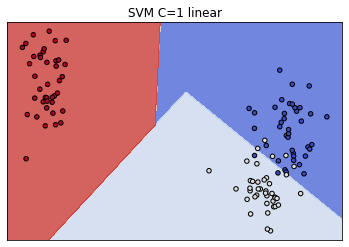

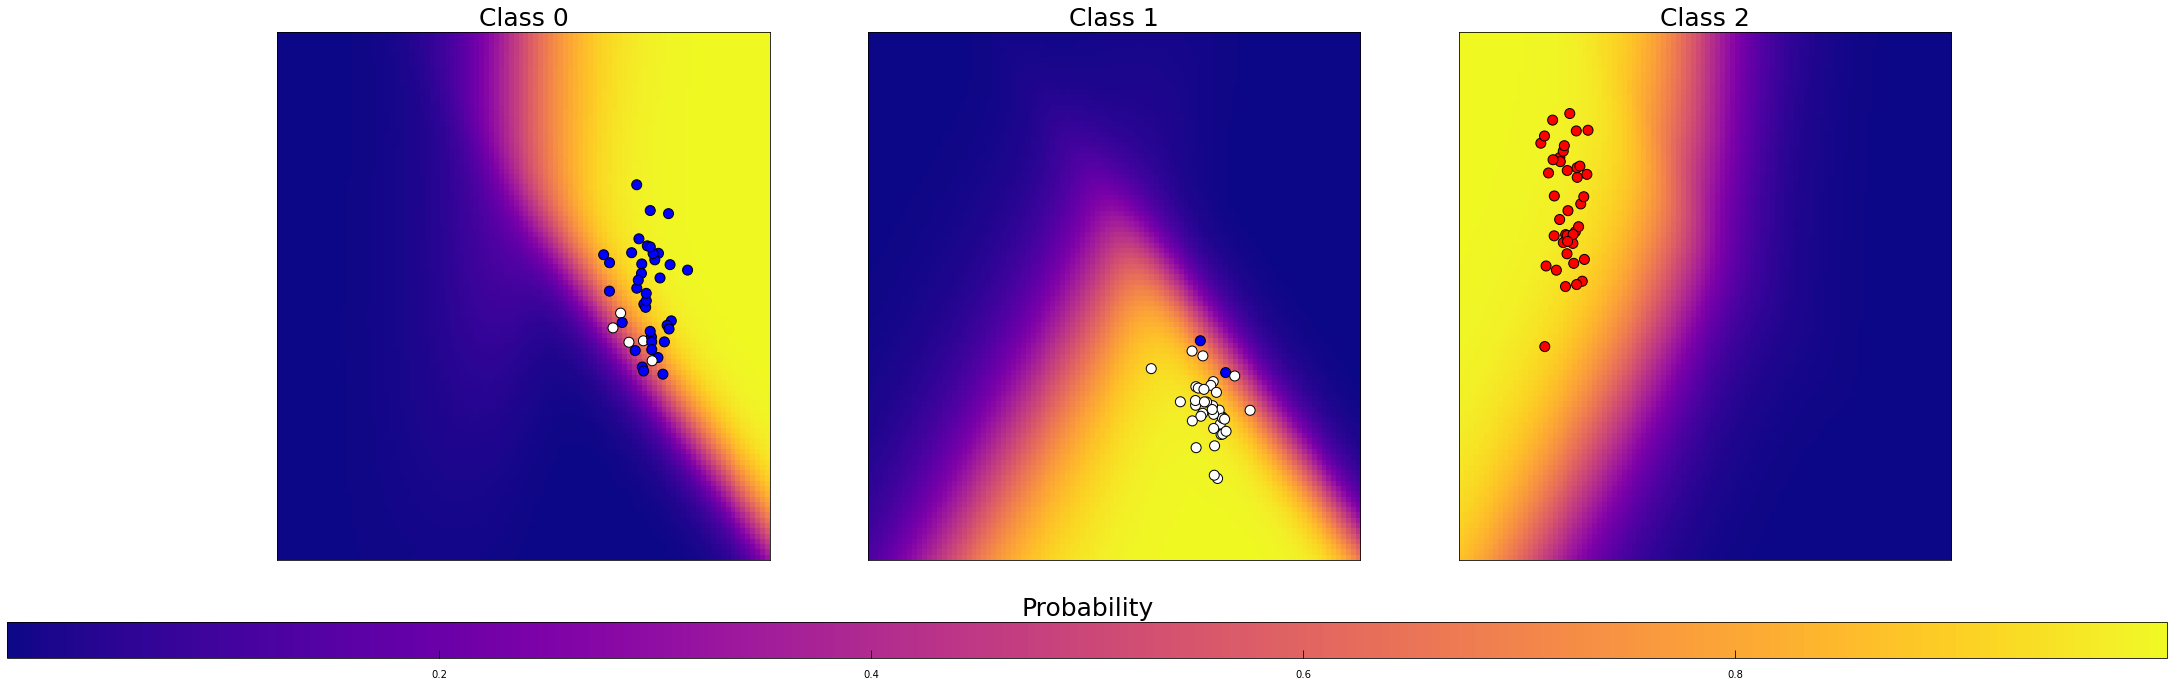

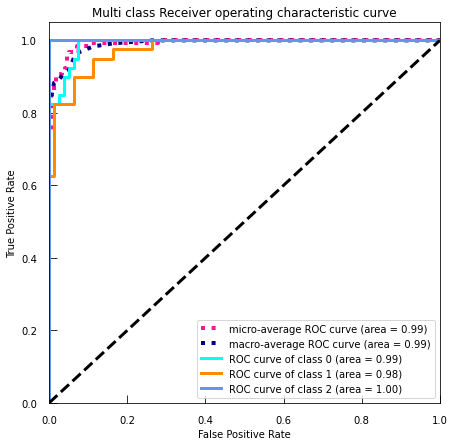

In [271]:
from utils import countour_SVM

#On multiple classes


countour_SVM(X_3,y_3,1,'linear',2,1,'ovr')#C=1 is the inverse of the weight on regularization, linear is the type of kernel used,
#2 here is the degree of the polynomial in case the kernel is polynomial(not relevant here), 1 is comparable to the variance on your Gaussian for
#the Gaussian radian kernel function (not relevant here), and ovr is one versus rest

The API offers us the possibility to have a probability for the decision function just like logistic regression (this is why I was able to plot those graphs). As I said before, this is not how the SVM works but it can be added after the learning to module decision. In particular the transformation used to get to the probability from the fit is a logistic function.... So it is a bit redundant and computationally demanding in my opinion... 

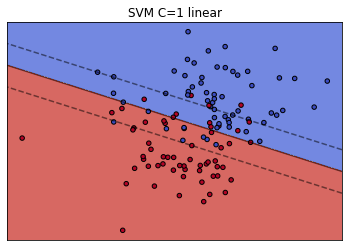

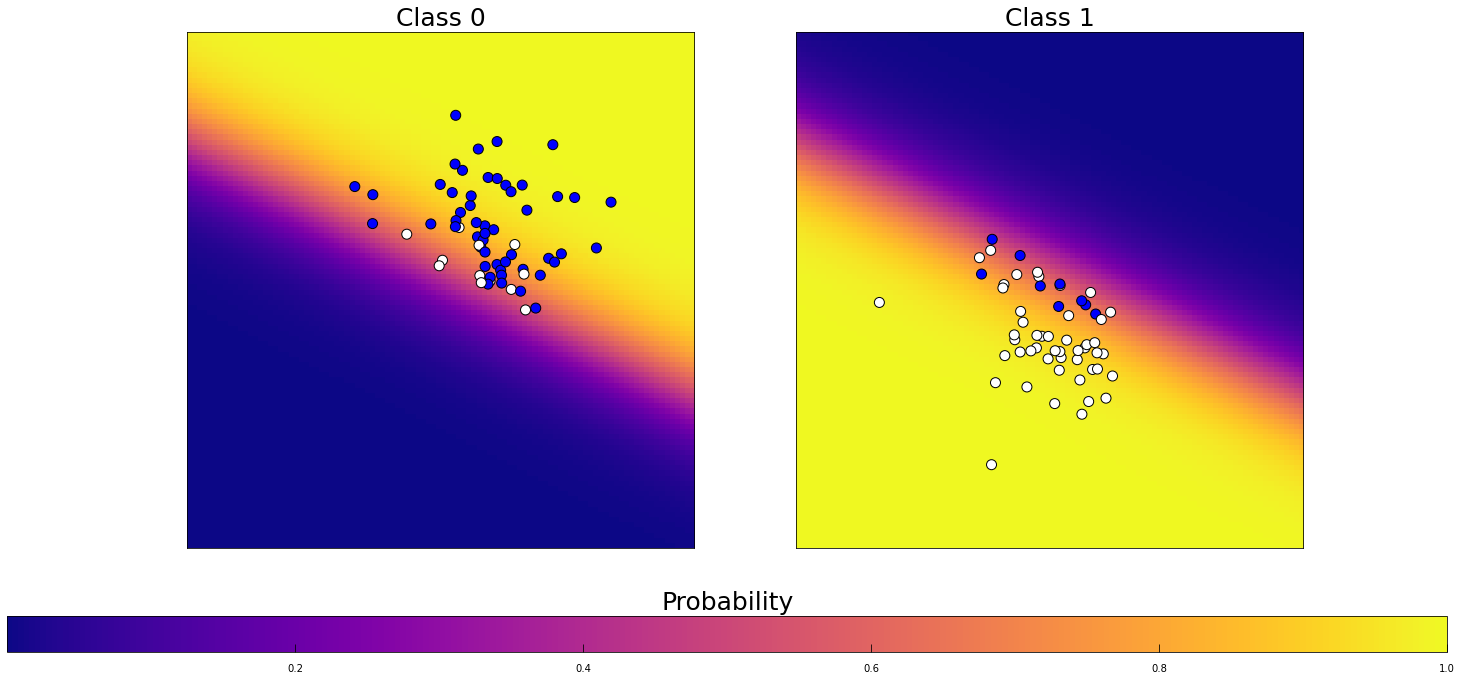

/home/seb/Documents/My_courses/crashcourseml/utils.py:545: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


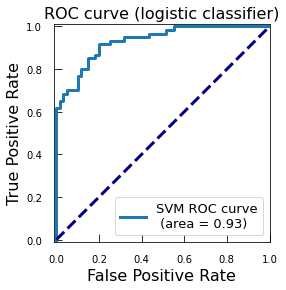

In [272]:
#only 2 classes
countour_SVM(X_toy_2,y_toy_2,1,'linear',2,1,'ovr')

In the first panel the hyperplan is the plain line whereas the dashed lines are just here to guide your eyes toward the support vector chosen here: i.e. the points in the different classes chosen so the hyperplan sits right in between them. You can see that in this case the classifier allows some missclassification.

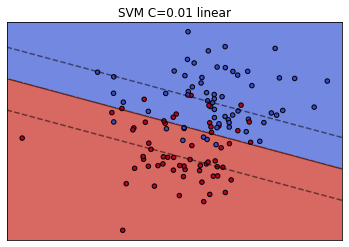

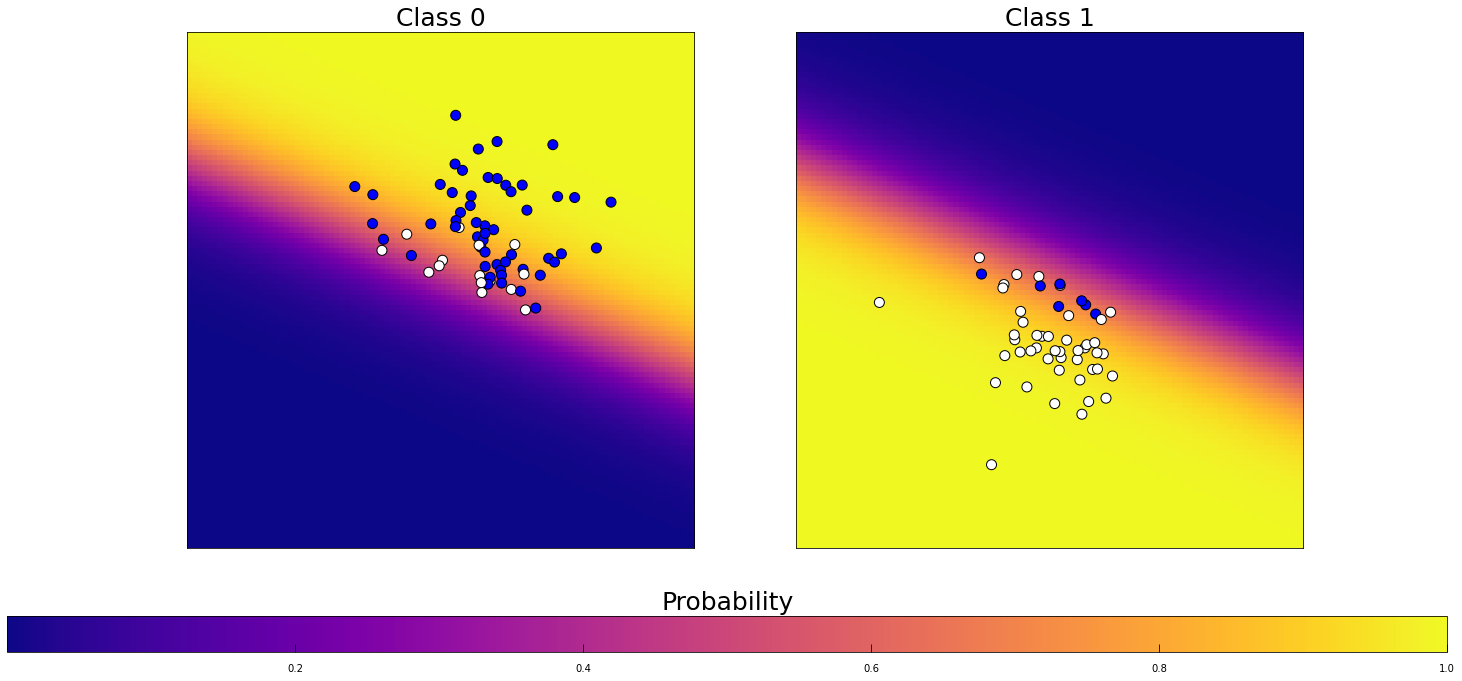

/home/seb/Documents/My_courses/crashcourseml/utils.py:545: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


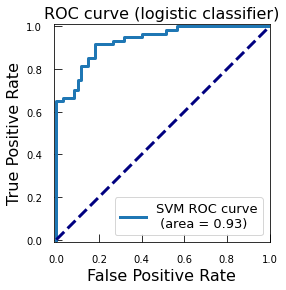

In [273]:
#let's put quite a lot of regularization
countour_SVM(X_toy_2,y_toy_2,0.01,'linear',2,1,'ovr')

Reducing C to 0.01 increases regularization and so allows the classifier to be more flexible. This allows more mislabelling and so the support verctors represented by the dashed lines can be even further from each other and include more misslabelling in the training set.

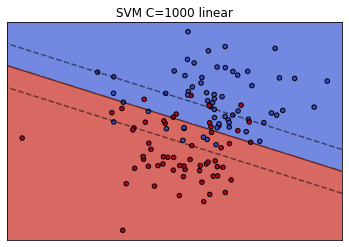

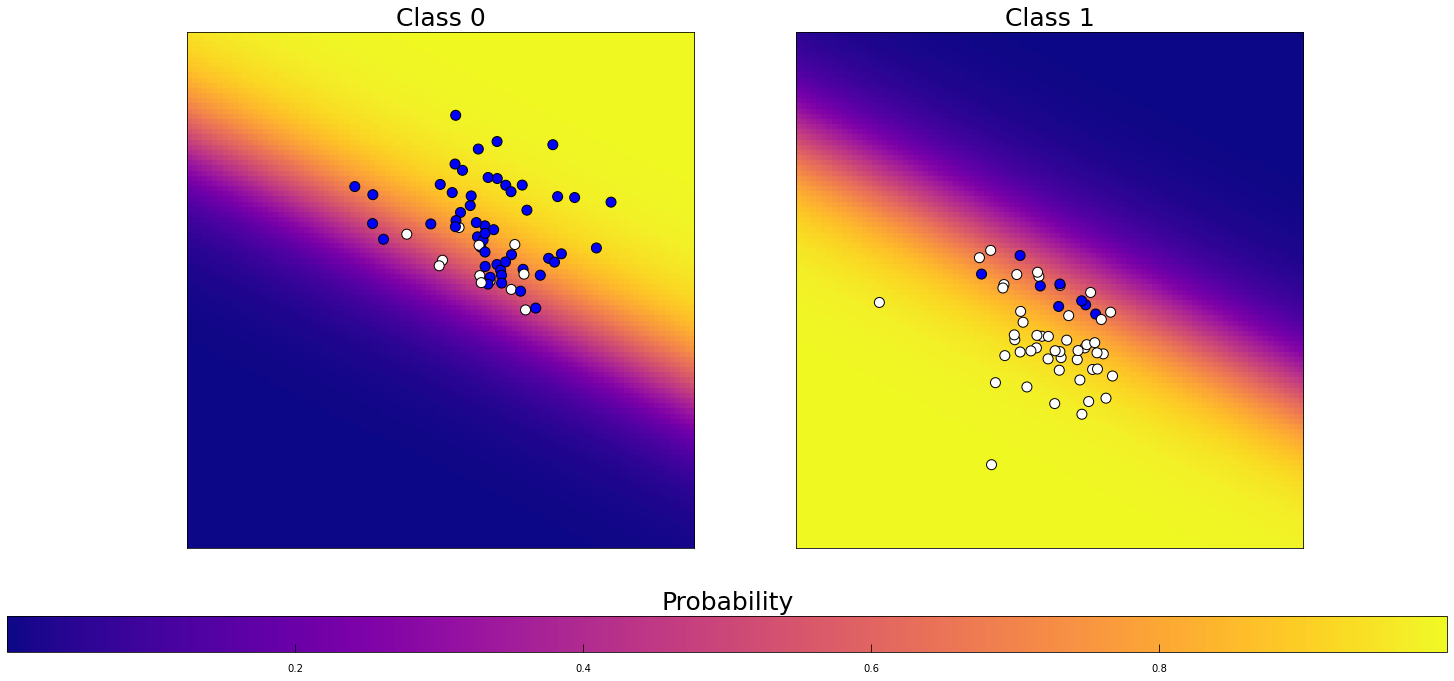

/home/seb/Documents/My_courses/crashcourseml/utils.py:545: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


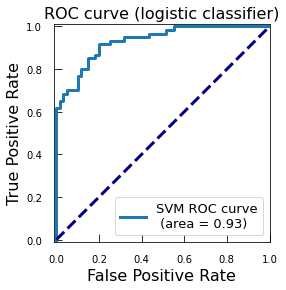

In [274]:
#let's put very little regularization
countour_SVM(X_toy_2,y_toy_2,1000,'linear',2,1,'ovr')

The inverse is true. Reducing the regularization brings the support vectors closer to each other and reduce the number of misslabels on the training set.

### Toy data non linear kernel <a class="anchor" id="SVM-nonlinear"></a>

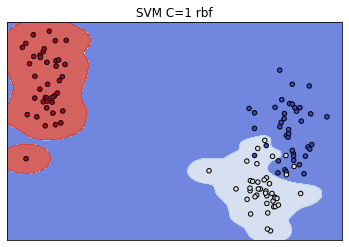

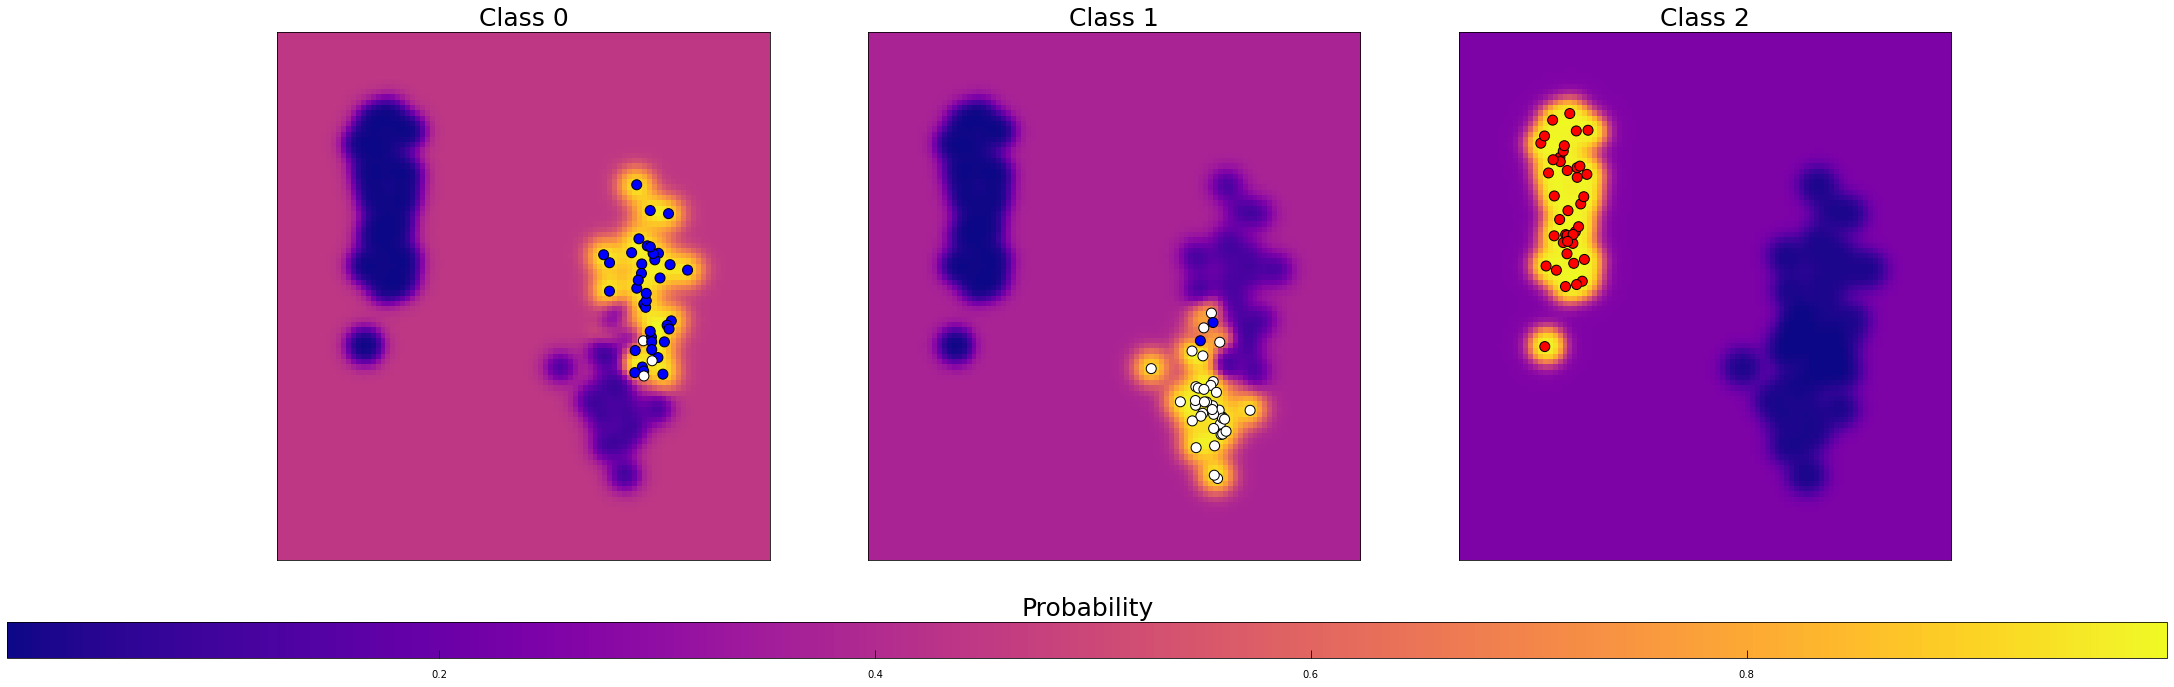

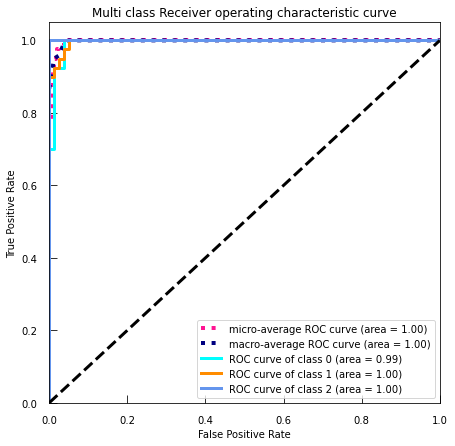

In [275]:
#let's change the scalar product and the notion of distance by using a rbf kernel
#Also we did'nt put much of regularization
countour_SVM(X_3,y_3,1,'rbf',2,1,'ovr')

In the above example we changed the kernel from linear to Gaussian radial basis. See how the classification boundaries are different from the linear model?

#####

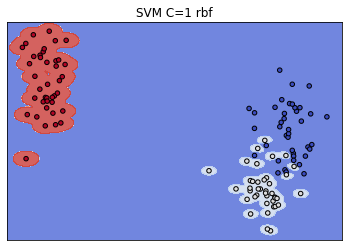

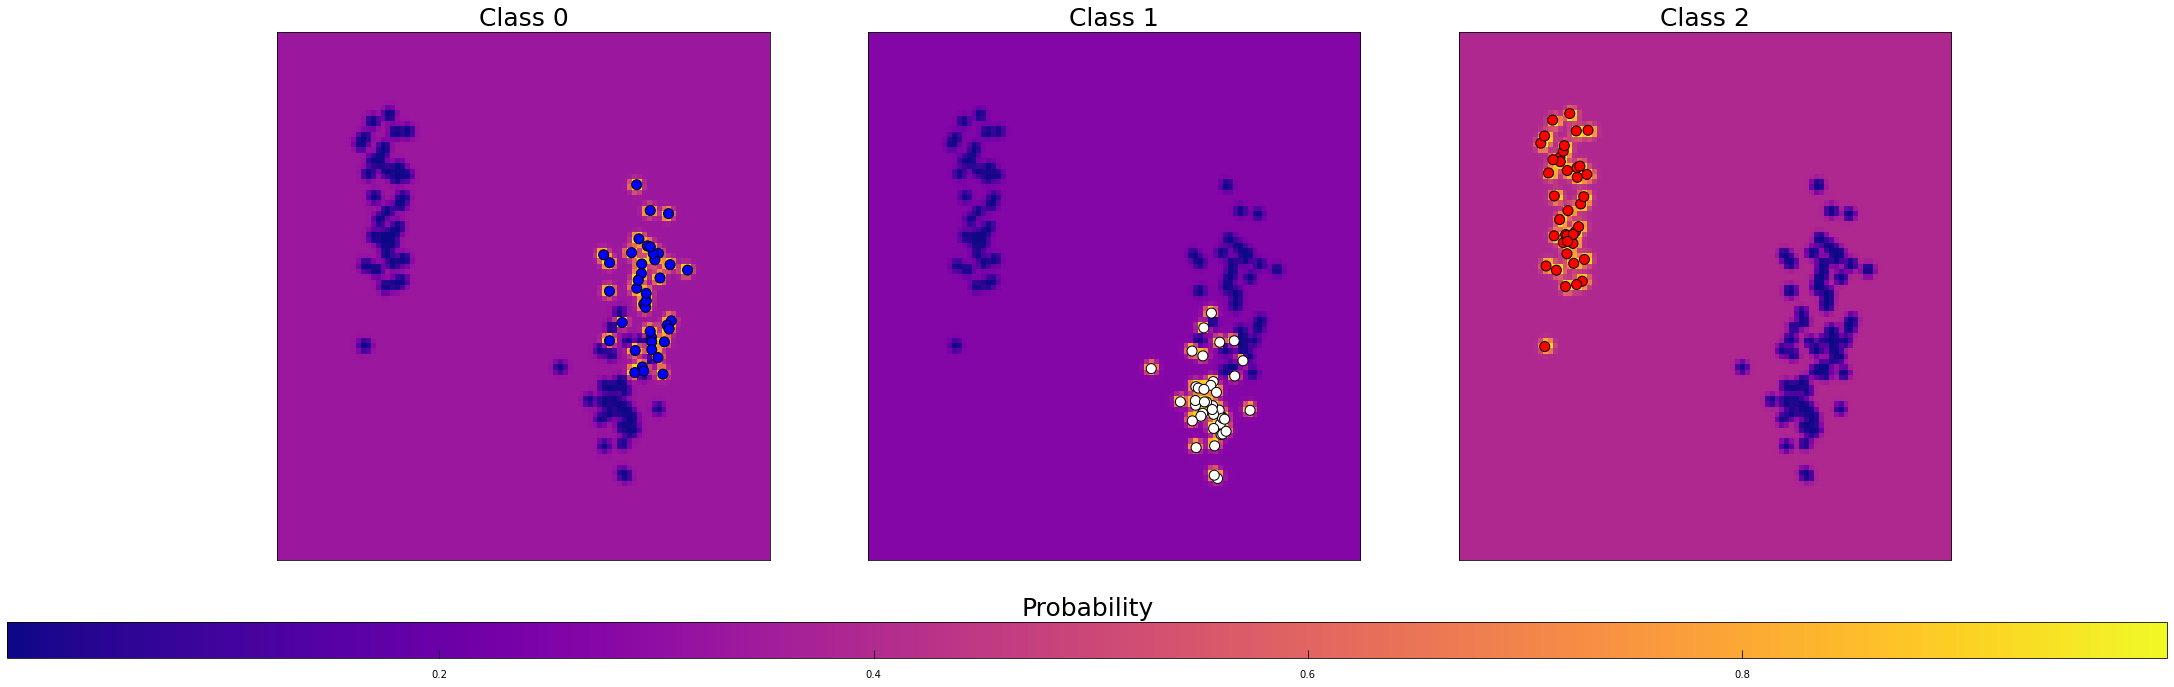

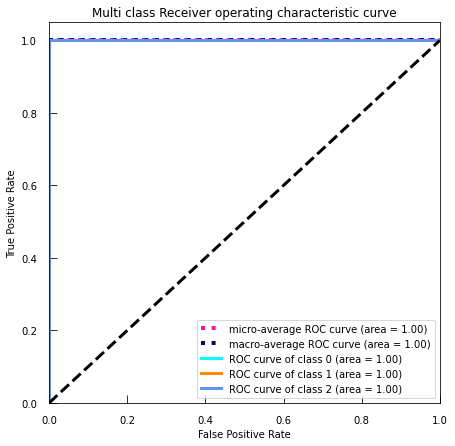

In [276]:
#even less regularization
countour_SVM(X_3,y_3,1,'rbf',2,10,'ovr')

In the above example we greatly reduce the standard deviation on the gaussian model (we increased $\gamma$). See how now the boundaries are really concentrated around each point? This $\gamma$ parameter can be linked to the number of neighbors in the KNN

#####

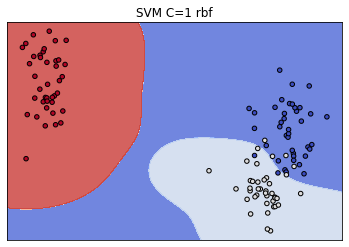

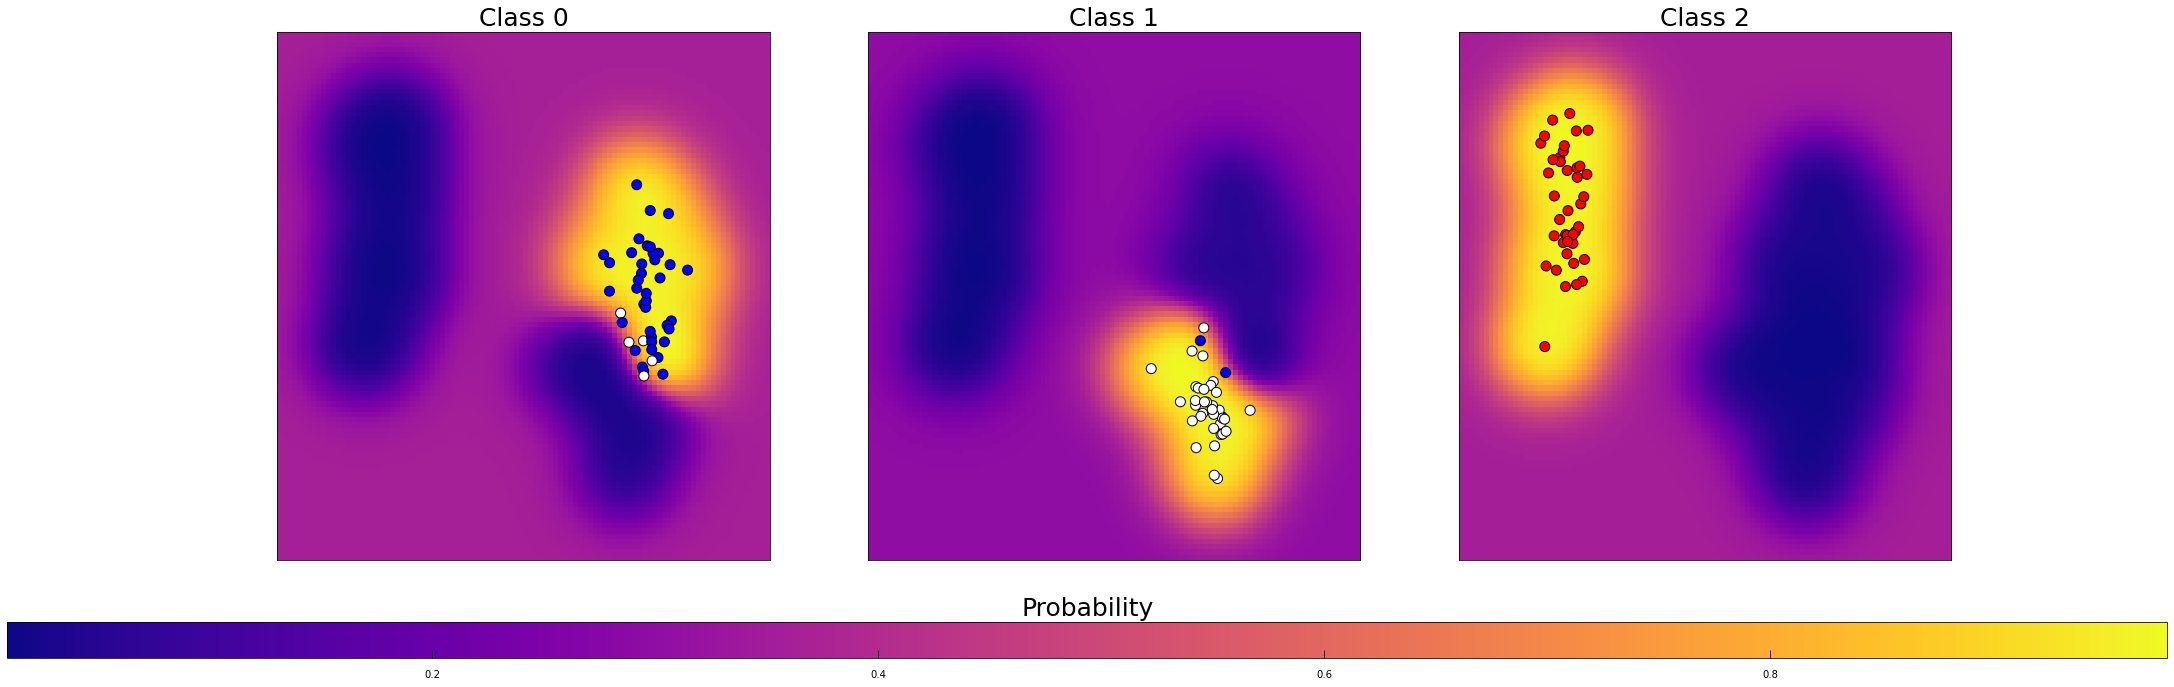

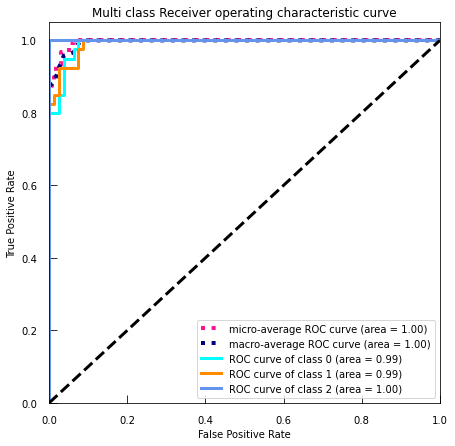

In [277]:
#more regularization
countour_SVM(X_3,y_3,1,'rbf',2,0.1,'ovr')

Inversely by expanding the variance in the gaussian we end up with larger chunks.

#### 

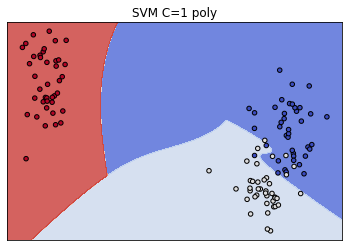

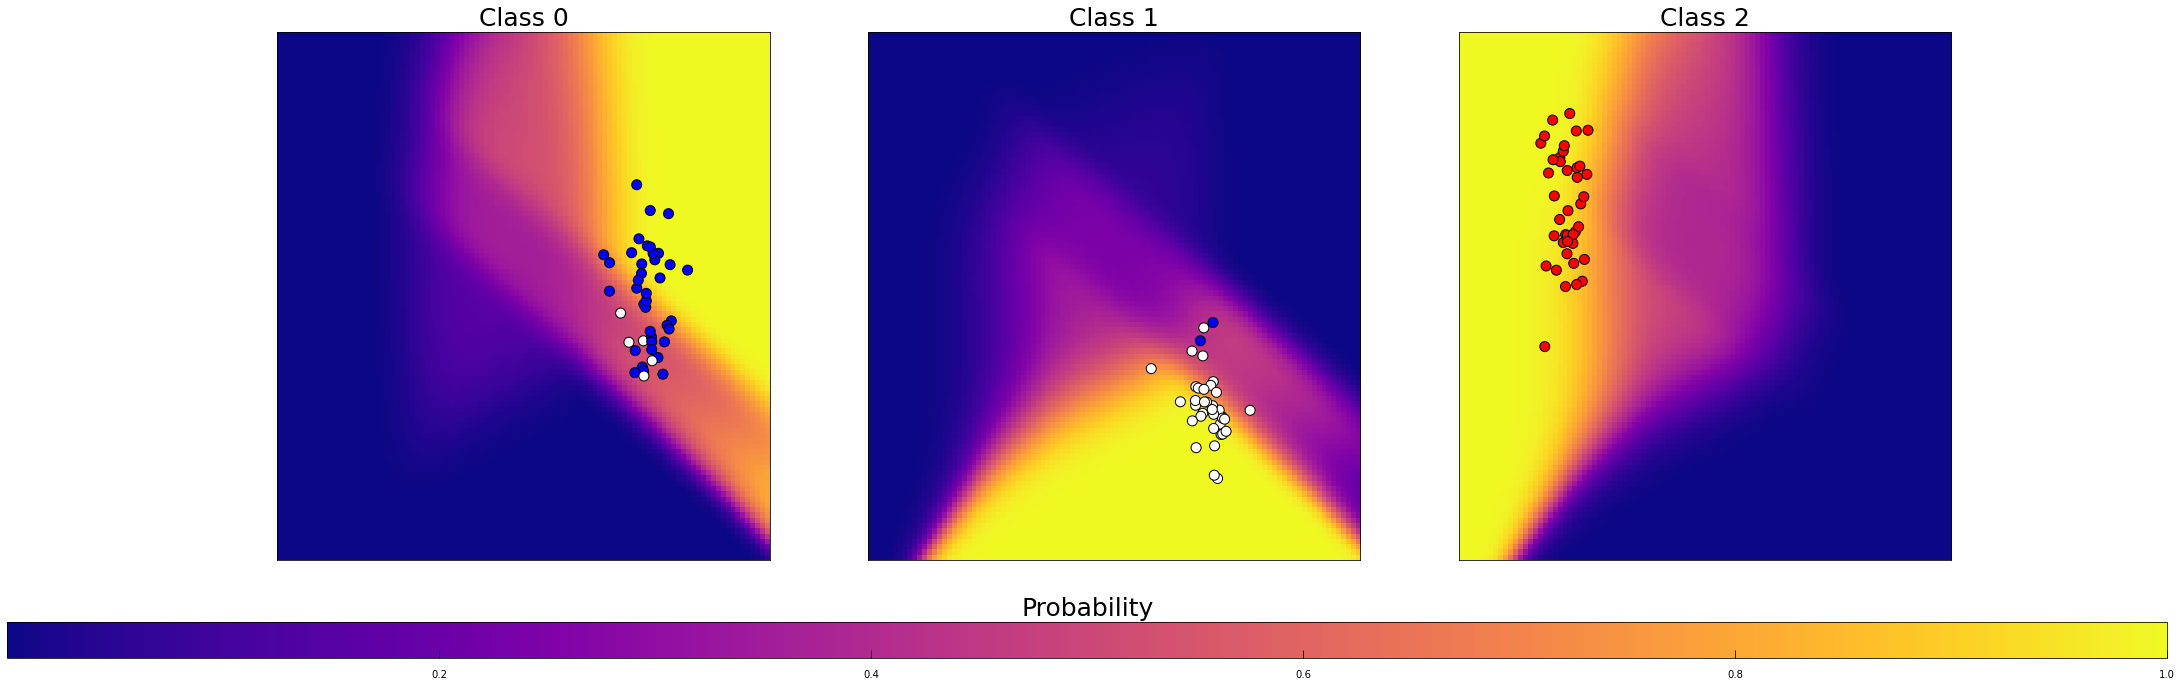

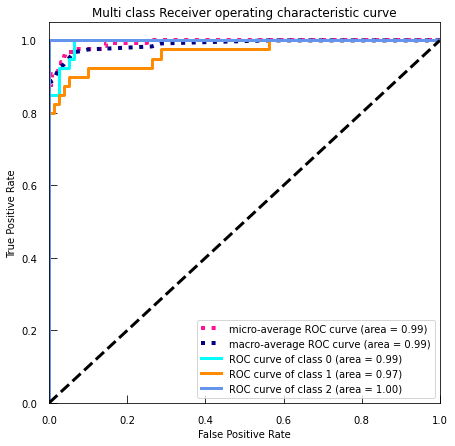

In [278]:
#little regularization but a polynomial kernel of degree 3 this time
countour_SVM(X_3,y_3,1,'poly',3,1,'ovr')

Finally, above we tried a degree 3 polynomial kernel?

### Cancer dataset <a class="anchor" id="SVM-hyperparameters"></a>

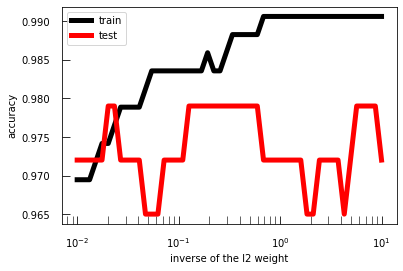

In [279]:
kernel_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for k in k_range: 
    SVM_r = svm.SVC(C=k, kernel='linear', degree=1, gamma= 1)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('inverse of the l2 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

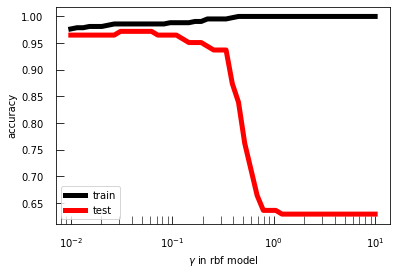

In [280]:

kernel_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for k in k_range: 
    SVM_r = svm.SVC(C=1, kernel='rbf', degree=1, gamma= k)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('$\gamma$ in rbf model')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

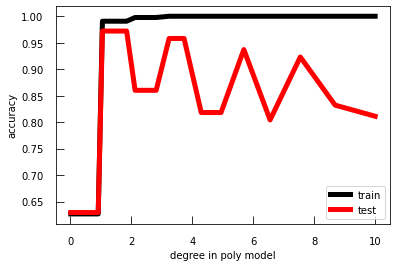

In [281]:
kernel_range=np.arange(0,20,1)


scores_test=[]
scores_train=[]

for k in k_range: 
    SVM_r = svm.SVC(C=1, kernel='poly', degree=k, gamma= 1)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('degree in poly model')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
#plt.xscale('log')
plt.legend(loc='best')
plt.show()

Those 3 hyperparameters show the usual overfitting behaviour when they are increased : monotonous increase of the accuracy on the train function whereas there is a maximum accuracy for the test function after which accuracy decreases with increasing hyperpaprameter value.

If you want to get the weights from the SVM just use coef_ again but it will only work if you are in the context of a linear SVC.

# Exercise <a class="anchor" id="exo"></a>

Using iris dataset compare and find the 'best' classifier. What do you learn from those classifiers? Don't forget that you have also seen stuff about preprocessing.

Don't go to crazy as it can be time consuming: big gridsize spacing.

Hint : before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. Try to make a list of grid_params where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
Example:

grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]

Questions : How would you work with your PCA data and incorporate it to your model?

Hint: Don't forget that PCA needs a centering and a scaling step...

Hint: adding PCA can be quite time consuming too. Try a small number of pca components first with other hyperparameters centered around what you found before!

In [282]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Next cell is correction!So work above!

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#




#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#


#

# One possible correction

In [283]:
pipe = Pipeline([('scalar',StandardScaler()),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 "classifier__weights": ['uniform','distance']
                 },
                {"classifier": [LogisticRegression(n_jobs=-1)],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(-2, 2, 10)
                 },
                {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf', 'poly'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__degree":np.arange(0,20,1),
                 "classifier__gamma": np.logspace(-2,1,10)}]

gridsearch_i = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search
best_model_i = gridsearch_i.fit(X_iris_train,y_iris_train)

print(best_model_i.best_estimator_)
print("Model accuracy:",best_model_i.score(X_iris_test,y_iris_test))

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', SVC(C=1.6681005372000592, degree=0, gamma=0.1))])
Model accuracy: 1.0


In [284]:
grid_param = [  {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__gamma": np.logspace(-2,1,10)}]

In [285]:
from sklearn.decomposition import PCA

pipe_pca = Pipeline([('scalar1',StandardScaler()),('pca',PCA(n_components=2)),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters

# create a gridsearch of the pipeline, the fit the best model
gridsearch_c_pca = GridSearchCV(pipe_pca, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search

best_model_c_pca = gridsearch_c_pca.fit(X_iris_train,y_iris_train)

In [286]:
print(best_model_c_pca.best_estimator_)
print("Model accuracy:",best_model_c_pca.score(X_iris_test,y_iris_test))

Pipeline(steps=[('scalar1', StandardScaler()), ('pca', PCA(n_components=2)),
                ('classifier',
                 SVC(C=4.6415888336127775, gamma=0.01, kernel='linear'))])
Model accuracy: 0.9473684210526315


In [287]:
pipe_pca = Pipeline([('scalar1',StandardScaler()),('pca',PCA(n_components=3)),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters

# create a gridsearch of the pipeline, the fit the best model
gridsearch_c_pca = GridSearchCV(pipe_pca, grid_param, cv=5, verbose=0,n_jobs=-1) # Fit grid search

best_model_c_pca = gridsearch_c_pca.fit(X_iris_train,y_iris_train)


print(best_model_c_pca.best_estimator_)
print("Model accuracy:",best_model_c_pca.score(X_iris_test,y_iris_test))

Pipeline(steps=[('scalar1', StandardScaler()), ('pca', PCA(n_components=3)),
                ('classifier',
                 SVC(C=12.915496650148826, gamma=0.021544346900318832))])
Model accuracy: 1.0
